In [ ]:
 # This is boilerplate code to correctly setup the settings to for notebook.
import os, sys
for root, dirs, files in os.walk(os.getcwd()):
    if root.split("/")[-1] == "pi0-analysis":
        pypath = os.getcwd() + "/pi0-analysis/analysis"

sys.path.insert(0, pypath)

from python.analysis.NotebookUtils import init_notebook
%init_notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/bhuller/Projects/xs_analysis/pi0-analysis/analysis
env: PYTHONPATH=/home/bhuller/Projects/xs_analysis/pi0-analysis/analysis


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import itertools
from rich import print
from rich.rule import Rule
import pandas as pd

import awkward as ak
import numpy as np
from python.analysis import cross_section, Plots, Tags, PFOSelection, SelectionTools, vector, Master

from apps import cex_analysis_input
from IPython.display import clear_output

from python.analysis import RegionIdentification


cross_section.PlotStyler.SetPlotStyle(dark = False, extend_colors = True, dpi = 100)

def process_tables(particle_counts, truncate : bool = True, exclude : list = [], head = 10):
    
    latex_labels = {"pi" : "$\pi^{\pm}$", "pi0" : "$\pi^{0}$", "gamma" : "$\gamma$", "proton" : "$p$", "neutron" : "$n$", "poor gamma" : "poor $\gamma$"}

    if truncate:
        truncated_counts = {}
        for k, v in particle_counts.items():
            if k in ["proton", "neutron"]:
                truncated_counts[k] = np.where(v > 3, "3+", v)
            else:
                truncated_counts[k] = v
    else:
        truncated_counts = {k : v for k,v in particle_counts.items()}

    for e in exclude:
        if e in truncated_counts:
            truncated_counts.pop(e)

    df = pd.DataFrame(truncated_counts, dtype = int)
    df = df.rename(columns = latex_labels)

    pd.options.display.multi_sparse = False
    # print(df.value_counts().head(head))
    table_series = df.value_counts(normalize = False)

    vp = df.value_counts(normalize = True)
    vc = df.value_counts(normalize = False)

    return pd.concat([pd.DataFrame(np.array(vc.index.to_list()), columns = list(vc.index.names)), pd.DataFrame({"counts" : vc.values, "fractions" : vp.values})], axis = 1)

def MakeTables(counts : dict):
    overall_tables = {p : process_tables(counts, True, [i for i in list(counts.keys()) if i != p]) for p in list(counts.keys())}

    process_table = process_tables(counts, True, head = None)
    process_table_no_neutron = process_tables(counts, True, ["neutron"], head = None)
    process_table_pions = process_tables(counts, True, ["neutron", "proton", "gamma", "non-beam", "poor gamma", "unknown"], head = None)
    process_table_pi_gamma = process_tables(counts, True, ["neutron", "proton", "pi0", "poor gamma", "unknown", "non-beam"], head = None)
    return {**overall_tables, "process_table" : process_table, "no_neutrons" : process_table_no_neutron, "pions_only" : process_table_pions, "pi_gamma" : process_table_pi_gamma}

def SaveTables(tables, path):
    cross_section.os.makedirs(path, exist_ok = True)
    for t in tables:
        tables[t].iloc[:10].style.format(precision = 2).hide(axis = "index").to_latex(f"{path}{t}.tex", multirow_align = "naive", sparse_index = False, convert_css = True)

    return

def MCParticleTopologies(mc, mc_particle_masks, bt_mc_particle_masks, mc_region_properties, region : str, process : str, path, region_dict, process_dict):
    print(Rule(f"region : {region}, process : {process}",))
    true_particle_counts, selected_pfo_counts, bt_particle_counts = MakeParticleCounts(mc, mc_particle_masks, bt_mc_particle_masks, mc_region_properties, region_dict, process_dict, region, process)
    
    print("true particle tables")
    true_tables = MakeTables(true_particle_counts)

    # return true_tables["process_table"]

    print("backracked particle tables")
    bt_tables = MakeTables(bt_particle_counts)

    print("selected PFO tables")
    selected_tables = MakeTables(selected_pfo_counts)

    if path is not None:
        out = f"{path}/{region}/{process}/"
        SaveTables(true_tables, out+"true/")
        SaveTables(bt_tables, out+"bt/")
        SaveTables(selected_tables, out+"selected/")

    return bt_tables


class CutOptimiser:
    def __init__(self, x : ak.Array, signal : ak.Array, n_cuts : int = 1, n_step = 50, x_range = None) -> None:
        self.x = x
        self.signal = signal
        self.n_cuts = n_cuts
        self.n_step = n_step
        self.x_range = x_range
        pass

    def p(self, selected_signal):
        return ak.sum(selected_signal)/ak.count(selected_signal)

    def e(self, selected_signal):
        return ak.sum(selected_signal)/ak.count(self.signal)

    def pe(self, selected_signal):
        return self.p(selected_signal) * self.e(selected_signal)

    def sb(self, selected_signal):
        return ak.sum(selected_signal) / ak.sum(~selected_signal)

    def ssb(self, selected_signal):
        return ak.sum(selected_signal) / np.sqrt(ak.sum(~selected_signal))

    def Optimise(self, score : callable, plot : bool = False):
        if self.x_range is None:
            cut_values = np.linspace(ak.min(self.x), ak.max(self.x), self.n_step)
        else:
            cut_values = np.linspace(min(self.x_range), max(self.x_range), self.n_step)

        score_l = []
        score_g = []
        for c in cut_values:
            mask = self.x < c
            score_l.append(score(self.signal[mask]))
            score_g.append(score(self.signal[~mask]))

        max_l = np.nanargmax(score_l)
        max_g = np.nanargmax(score_g)
        
        if score_l[max_l] > score_g[max_g]:
            op = "<"
            cut_value = cut_values[max_l]
        else:
            op = ">"
            cut_value = cut_values[max_g]

        if plot is True:
            Plots.Plot(cut_values, score_l, xlabel = "cut value", ylabel = "score", label = "x < c", newFigure = False)
            Plots.Plot(cut_values, score_g, label = "x > c", newFigure = False)
            Plots.Plot(cut_values[max_l], score_l[max_l], marker = "X", newFigure = False)
            Plots.Plot(cut_values[max_g], score_g[max_g], marker = "X", newFigure = False)
        return cut_value, op

    def visualise(self, cut_value, cut_op, tags : Tags = None, x_label = None):
        if tags is None:
            tags = Tags.Tags()
            tags["signal"] = Tags.Tag(name = "signal", mask = self.signal, colour = "C6", number = 0)
            tags["background"] = Tags.Tag(name = "background", mask = ~self.signal, colour = "C0", number = 1)
        Plots.PlotTagged(self.x, tags, x_label = x_label, x_range = self.x_range, truncate = self.x_range is not None, newFigure = False, histtype = "step", stacked = False, norm = False)
        
        if self.x_range is None:
            l = ak.max(self.x)
        else:
            l = max(self.x_range)
        Plots.DrawCutPosition(cut_value, face = cut_op, arrow_length = 0.1 * l)


def CreateMatrix(x, y):
    mat = np.zeros([max(x) + 1, max(y) + 1])
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            mat[i, j] = sum((x == i) & (y == j))
    return mat

def CreateMatrix3D(x, y, z):
    mat = np.zeros([max(x) + 1, max(y) + 1, max(z) + 1])
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            for k in range(mat.shape[2]):
                mat[i, j, k] = sum((x == i) & (y == j) & (z == k))
    return mat

def PlotMat(mat, x_label, y_label, title : str = None, newFigure = True):
    if newFigure is True: Plots.plt.figure()
    Plots.plt.imshow(mat, origin = "lower", cmap = "cool")
    Plots.plt.xlabel(x_label)
    Plots.plt.ylabel(y_label)
    Plots.plt.grid(False)
    Plots.plt.title(title)

    for (i, j), z in np.ndenumerate(mat):
        Plots.plt.text(j, i, int(z), ha='center', va='center', weight = "bold")
    # Plots.plt.tight_layout()
    return

def gamma_veto(regions, photon_counts):
    regions_dict = {
        "absorption": regions["absorption"] & (photon_counts == 0),
        "charge_exchange": regions["charge_exchange"],
        "single_pion_production": regions["single_pion_production"] & (photon_counts == 0),
        "pion_production" : regions["pion_production"]
    }
    return regions_dict

def gamma_veto_spip_migrate(regions, regions_gamma_veto, photon_counts, target):
    rejected = regions["single_pion_production"] & (photon_counts > 0)

    regions_dict = {k : v for k, v in regions_gamma_veto.items()}
    regions_dict[target] = regions_dict[target] | rejected
    return regions_dict

def gamma_veto_abs_migrate(regions, regions_gamma_veto, photon_counts, target):
    rejected = regions["absorption"] & (photon_counts > 0)
    
    regions_dict = {k : v for k, v in regions_gamma_veto.items()}
    regions_dict[target] = regions_dict[target] | rejected
    return regions_dict


def TrueParticleMasks(trueParticles : Master.TrueParticleData | Master.TrueParticleDataBT):
    tp  = trueParticles.events.trueParticles # required specifically for listing pi0s
    beam_pi0 = (tp.pdg == 111) & (tp.mother == 1)

    photon_mothers = np.where(trueParticles.pdg == 22, trueParticles.mother, 0)

    beam_pi0_photon = []

    for i, j in zip(photon_mothers, tp.number[beam_pi0]):
        if len(j) == 0:
            beam_pi0_photon.append(np.zeros_like(i, dtype = bool))
        else:
            beam_pi0_photon.append(ak.any([i == k for k in j], 0))
    beam_pi0_photon = ak.Array(beam_pi0_photon)

    masks = {
        "true_pi_mask" : (trueParticles.pdg == 211) | (trueParticles.pdg == -211),
        "true_proton_mask" : trueParticles.pdg == 2212,
        "true_neutron_mask" : trueParticles.pdg == 2112,
        "true_non_beam_mask" : trueParticles.number != 1,
        "true_beam_daughter" : trueParticles.mother == 1,
        "true_gamma_mask" : trueParticles.pdg == 22,
        "true_pi0_mask" : trueParticles.pdg == 111,
        "beam_pi0_photon" : beam_pi0_photon,
        "beam_pi0" : beam_pi0,
    }
    masks["non_beam_product_mask"] = (~masks["true_beam_daughter"]) & masks["true_non_beam_mask"] & (~beam_pi0_photon)
    if type(trueParticles) == Master.TrueParticleDataBT:
        # cannot backtrack a PFO to a pi0
        masks.pop("true_pi0_mask")
        masks.pop("beam_pi0")
    return masks


def CountPi0sBT(mc_beam : Master.Data, particle_masks_bt):
    pi0_counts_bt = []
    for i in mc_beam.trueParticlesBT.mother[particle_masks_bt["beam_pi0_photon"]]:
        _, counts = np.unique(i, return_counts = True)
        pi0_counts_bt.append(sum(counts >=2))

    pi0_counts_bt = ak.Array(pi0_counts_bt)
    return pi0_counts_bt


def MakeParticleCounts(mc_beam : dict, particle_masks : dict, particle_masks_bt : dict, region_properties : dict, mc_regions : dict, mc_process : dict, region : str = None, process : str = None):

    if region is not None:
        rr = mc_regions[region]
    else:
        rr = np.ones_like(mc_beam.eventNum, dtype = bool)

    if process is not None:
        tr = mc_process[process]
    else:
        tr = np.ones_like(mc_beam.eventNum, dtype = bool)

    beam_daughters = particle_masks["true_non_beam_mask"] & particle_masks["true_beam_daughter"]

    nParticles = {
        "pi" : ak.num(mc_beam.trueParticles.pdg[beam_daughters & particle_masks["true_pi_mask"]], -1)[tr & rr],
        "gamma" : ak.num(mc_beam.trueParticles.pdg[particle_masks["true_non_beam_mask"] & particle_masks["true_gamma_mask"] & particle_masks["beam_pi0_photon"]], -1)[tr & rr],
        "pi0" : ak.num(mc_beam.trueParticles.pdg[beam_daughters & particle_masks["true_pi0_mask"]], -1)[tr & rr],
        "proton" : ak.num(mc_beam.trueParticles.pdg[beam_daughters & particle_masks["true_proton_mask"]], -1)[tr & rr],
        "neutron" : ak.num(mc_beam.trueParticles.pdg[beam_daughters & particle_masks["true_neutron_mask"]], -1)[tr & rr],
        "non-beam" : ak.num(mc_beam.trueParticles.pdg[particle_masks["non_beam_product_mask"]], -1)[tr & rr]
    }

    beam_daughters = particle_masks_bt["true_non_beam_mask"] & particle_masks_bt["true_beam_daughter"]
    nReconstructedParticles = {
        "pi" : ak.num(mc_beam.trueParticlesBT.pdg[beam_daughters & particle_masks_bt["true_pi_mask"]], -1)[tr & rr],
        "gamma" : ak.num(mc_beam.trueParticlesBT.pdg[particle_masks_bt["true_non_beam_mask"] & particle_masks_bt["true_gamma_mask"] & particle_masks_bt["beam_pi0_photon"]], -1)[tr & rr],
        "pi0" : CountPi0sBT(mc_beam, particle_masks_bt)[tr & rr],
        "proton" : ak.num(mc_beam.trueParticlesBT.pdg[beam_daughters & particle_masks_bt["true_proton_mask"]], -1)[tr & rr],
        "neutron" : ak.num(mc_beam.trueParticlesBT.pdg[beam_daughters & particle_masks_bt["true_neutron_mask"]], -1)[tr & rr],
        "non-beam" : ak.num(mc_beam.trueParticlesBT.pdg[particle_masks_bt["non_beam_product_mask"]], -1)[tr & rr]
    }

    def count_pfo(mask):
        return ak.sum(tr & mask, -1)[tr & rr]
    nSelectedPFOs = {
        "pi" : count_pfo(region_properties["pi_mask"]),
        "gamma" : count_pfo(region_properties["photon_mask"]),
        "pi0" : count_pfo(region_properties["pi0_mask"]),
        # "poor gamma" : count_pfo(region_properties["poor_photon_mask"]),
        # "proton" : count_pfo(region_properties["proton_mask"]),
        # "unknown" : count_pfo(region_properties["unknown_pfo_mask"])
    }
    return nParticles, nSelectedPFOs, nReconstructedParticles

def pec(mask, total):
   selected = total[mask]
   p = ak.sum(selected) / ak.count(selected)
   e = ak.sum(selected) / ak.sum(total)
   c = ak.sum(selected)
   return p, e, c


def FormatTable(filename):
    with open(filename) as file:
        lines = list(file.readlines())
        new_lines = []
        for i, l in enumerate(lines):
            if i == 1:
                entries = l.split(" & ")
                formatted = []
                for j in range(len(entries)):
                    if j == len(entries) - 1:
                        s = entries[j].split(" \\\\\n")[0]
                        formatted.append(f"\\boldmath\\textbf{{{s}}}" + " \\\\\n")
                    else:
                        formatted.append(f"\\boldmath\\textbf{{{entries[j]}}} & ")
                formatted = "".join(formatted)
                new_lines.append(formatted)
            else:
                new_lines.append(l)

        ruled_lines = []
        for i, l in enumerate(new_lines):
            ruled_lines.append(l)
            if i in [1, len(new_lines) - 2]:
                ruled_lines.append("\\hhline\n")
            elif i in [0, len(new_lines) - 1]:
                continue
            else:
                ruled_lines.append("\\hdashline\n")
    with open(filename, "w") as file:
        file.writelines(ruled_lines)
    return


def nearest_separation(sample : Master.Data):
    max_n = max(ak.num(sample.recoParticles.number))

    padded_pos = ak.pad_none(sample.recoParticles.shower_start_pos, max_n, -1)

    sep = []
    for i in range(max_n):
        sep.append(ak.max(ak.concatenate([ak.unflatten(vector.dist(padded_pos[:, i], sample.recoParticles.beam_endPos), 1, -1), vector.dist(padded_pos[:, i], sample.recoParticles.shower_start_pos)], -1), -1))

    sep = ak.concatenate(ak.unflatten(sep, 1, -1), -1)
    sep = sep[~ak.is_none(sep, -1)]
    return sep


def PlotRegionConfusionMatrix(reco_region : dict, true_region : dict, title = None):
    counts = cross_section.CountInRegions(true_region, reco_region)
    Plots.PlotConfusionMatrix(counts, list(reco_region.keys()), list(true_region.keys()), y_label = "true process", x_label = "reco region", title = title, newFigure = True)    
    return


env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [2]:
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration("work/2023/analysis_2GeV_new_pfo_selection/analysis_config.json"))
# print(vars(args))

In [3]:
mc = cross_section.Data(args.mc_file, nTuple_type = cross_section.Ntuple_Type.PDSP, target_momentum = args.pmom)
data = cross_section.Data(args.data_file, nTuple_type = cross_section.Ntuple_Type.PDSP)

In [4]:
mc_beam = cex_analysis_input.BeamPionSelection(mc, args, True)
data_beam = cex_analysis_input.BeamPionSelection(data, args, False)

mc_reco_regions, mc_true_regions = cex_analysis_input.RegionSelection(mc, args, True)
data_reco_regions = cex_analysis_input.RegionSelection(data, args, False)

'BeamPionSelection' executed in 0.0413s

'BeamPionSelection' executed in 0.1374s

'RegionSelection' executed in 8.7514s

'RegionSelection' executed in 5.4819s

In [5]:
def region_properties(args, sample):
    region_properties = {
        "photon_mask" : SelectionTools.CombineMasks(args.selection_masks[sample]["photon"]),
        "pi_mask" : SelectionTools.CombineMasks(args.selection_masks[sample]["pi"]),
        "pi0_mask" : SelectionTools.CombineMasks(args.selection_masks[sample]["pi0"]),
        "loose_pi_mask" : SelectionTools.CombineMasks(args.selection_masks[sample]["loose_pi"]),
        "loose_photon_mask" : SelectionTools.CombineMasks(args.selection_masks[sample]["loose_photon"]),

        "n_pi" : SelectionTools.GetPFOCounts(args.selection_masks[sample]["pi"]),
        "n_pi0" : SelectionTools.GetPFOCounts(args.selection_masks[sample]["pi0"]),
        "n_photon" : SelectionTools.GetPFOCounts(args.selection_masks[sample]["photon"]),
        "n_loose_pi" : SelectionTools.GetPFOCounts(args.selection_masks[sample]["loose_pi"]),
        "n_loose_photon" : SelectionTools.GetPFOCounts(args.selection_masks[sample]["loose_photon"]),
    }

    return region_properties

mc_region_properties = region_properties(args, "mc")
data_region_properties = region_properties(args, "data")

In [6]:
mc_particle_masks = TrueParticleMasks(mc_beam.trueParticles)
bt_mc_particle_masks = TrueParticleMasks(mc_beam.trueParticlesBT)

# Particle Tables

In [116]:
for r in mc_reco_regions:
    for t in mc_true_regions:
        MCParticleTopologies(r, t, "test/particle_tables")
        clear_output()

for f in [cross_section.os.path.join(dp, f) for dp, dn, fn in cross_section.os.walk(cross_section.os.path.expanduser("test/particle_tables")) for f in fn]:
    FormatTable(f)

# table = MCParticleTopologies("charge_exchange", "pion_production", None)
# print(table)

# Reco PFO Properties

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


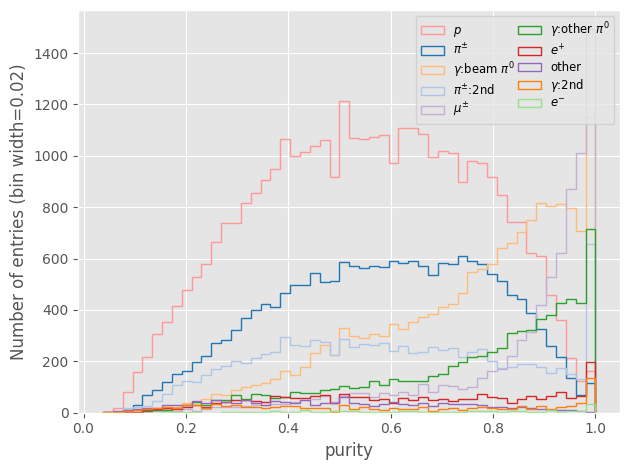

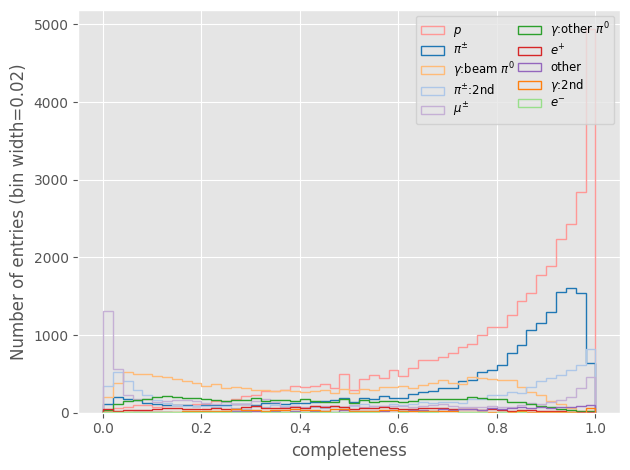

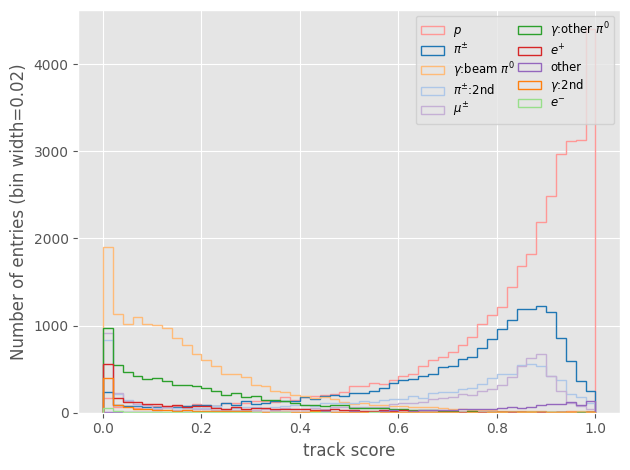

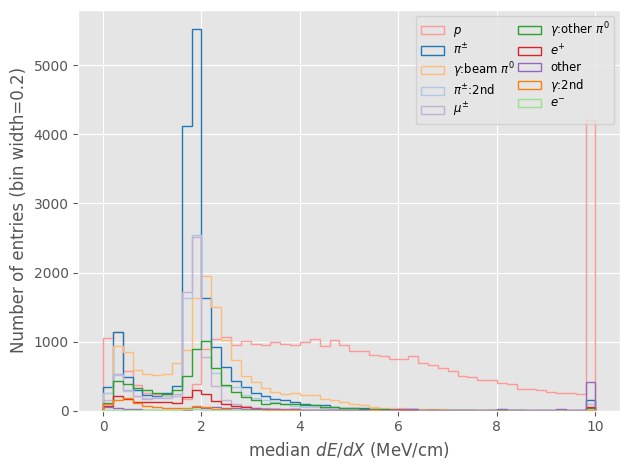

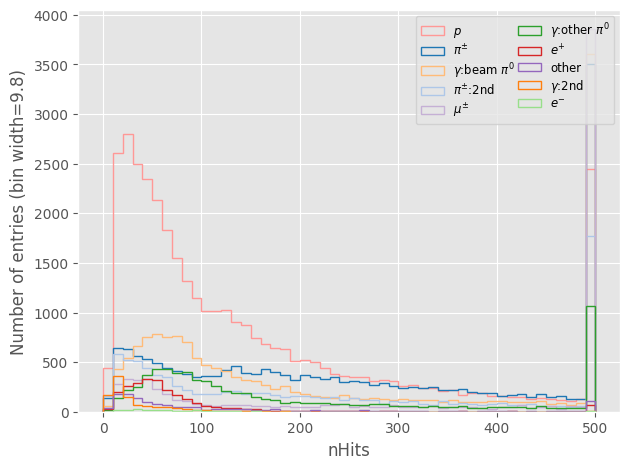

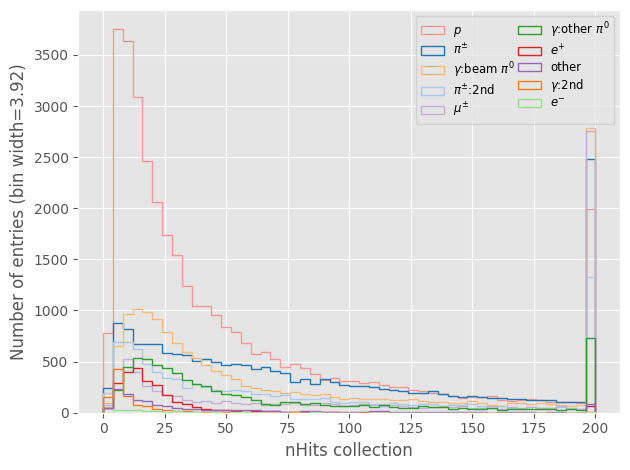

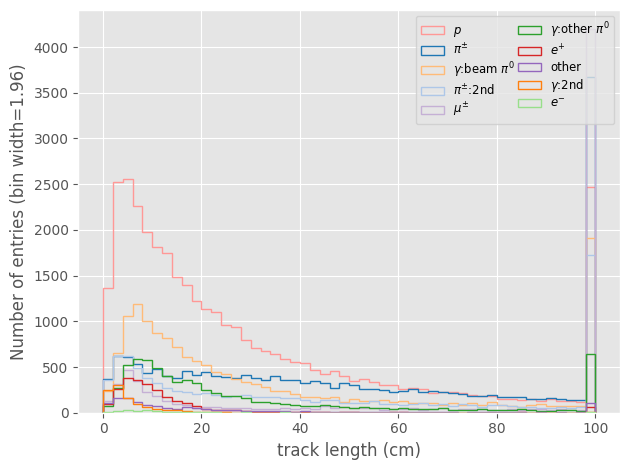

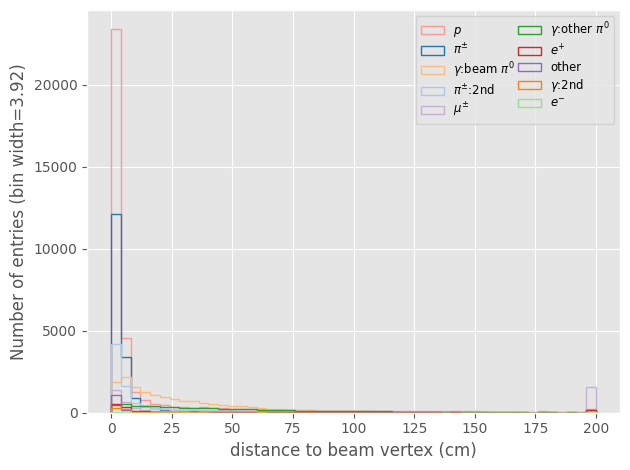

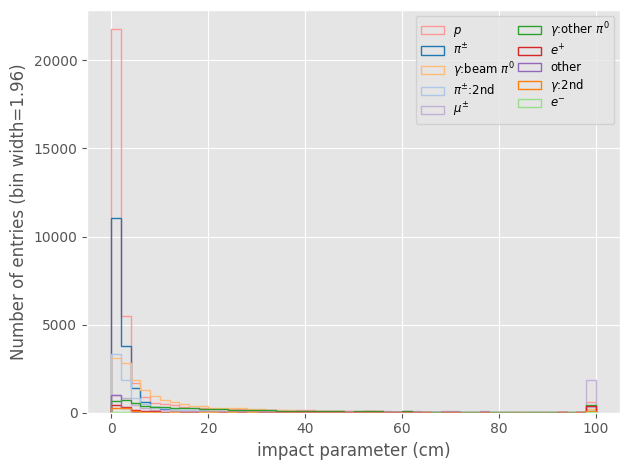

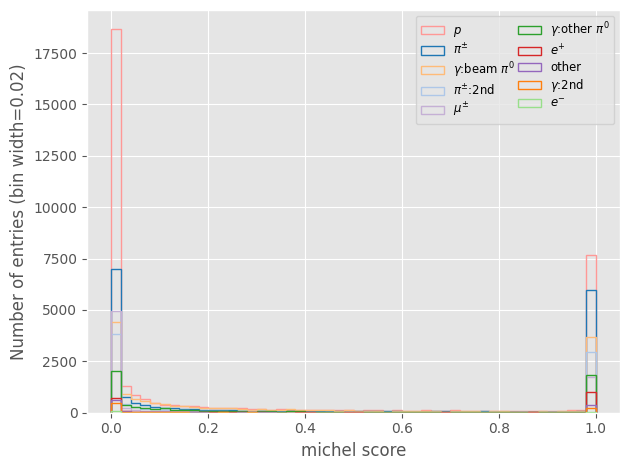

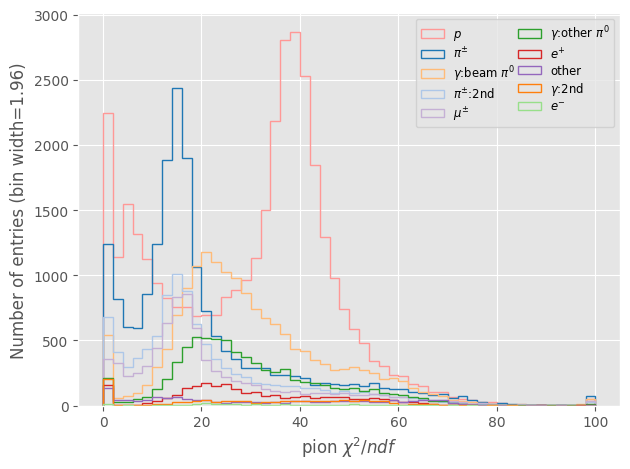

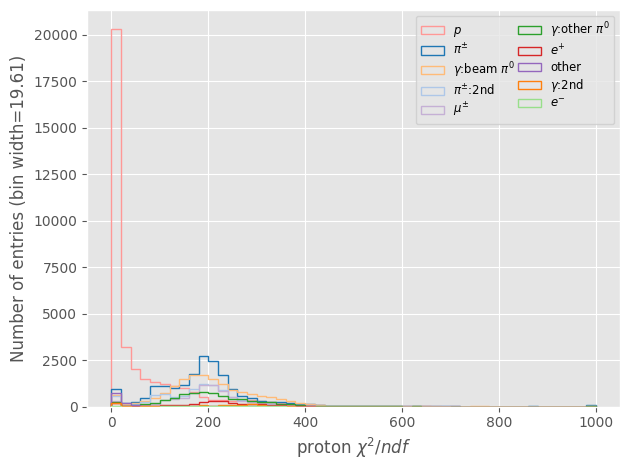

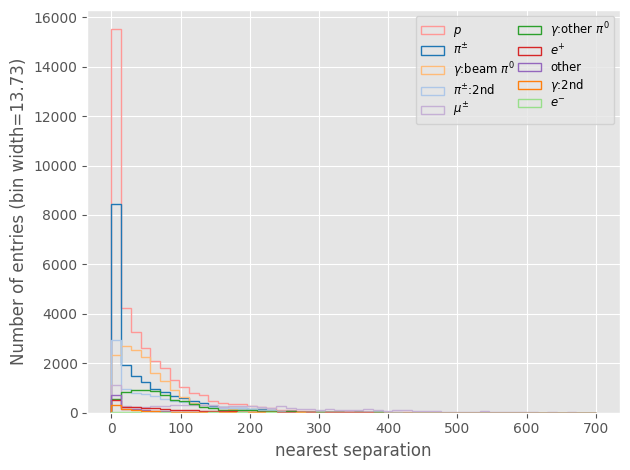

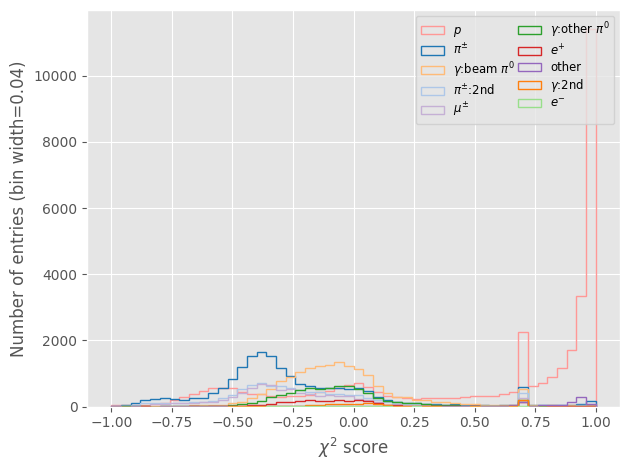

In [7]:
# mask = mc_true_regions["pion_production"] | (~mc_true_regions["pion_production"])

# mask = mc_region_properties["unknown_pfo_mask"] # look at PFOs which were not identified as anything

tags = Tags.GenerateTrueParticleTagsInterestingPFOs(mc_beam)

for t in tags:
    tags[t].mask = tags[t].mask

observables = {
    "purity" : mc_beam.trueParticlesBT.purity,
    "completeness" : mc_beam.trueParticlesBT.completeness,
    "track_score" : PFOSelection.TrackScoreCut(mc_beam, return_property = True)[1],
    "median_dEdX" : PFOSelection.PiPlusSelection(mc_beam, return_property = True)[1],
    "nHits" : PFOSelection.NHitsCut(mc_beam, return_property = True)[1],
    "nHits_collection" : mc_beam.recoParticles.n_hits_collection,
    "track_length" : mc_beam.recoParticles.track_len,
    "beam_dist" : PFOSelection.BeamParticleDistanceCut(mc_beam, return_property = True)[1],
    "beam_ip" : PFOSelection.BeamParticleIPCut(mc_beam, return_property = True)[1],
    "michel_score" : mc_beam.recoParticles.track_vertex_michel,
    "chi2_pion" : mc_beam.recoParticles.track_chi2_pion / mc_beam.recoParticles.track_chi2_pion_ndof,
    "chi2_proton" : mc_beam.recoParticles.track_chi2_proton / mc_beam.recoParticles.track_chi2_proton_ndof,
    "nearest_separation" : nearest_separation(mc_beam)
}

chi2_pi_norm = observables["chi2_pion"] / ak.max(observables["chi2_pion"])
chi2_p_norm = observables["chi2_proton"] / ak.max(observables["chi2_proton"])
score = (chi2_pi_norm - chi2_p_norm) / (chi2_pi_norm + chi2_p_norm)

observables["chi2_score"] = score

ranges = {
    "purity"           : None,
    "completeness"     : None,
    "track_score"      : None,
    "median_dEdX"      : [0, 10],
    "nHits"            : [0, 500],
    "nHits_collection" : [0, 200],
    "track_length"     : [0, 100],
    "beam_dist"        : [0, 200],
    "beam_ip"          : [0, 100],
    "michel_score"     : [0, 1],
    "chi2_pion"        : [0, 100],
    "chi2_proton"      : [0, 1000],
    "nearest_separation" : [0, 700],
    "chi2_score"       : [-1, 1],

}

x_labels = {
    "purity"             : "purity",
    "completeness"       : "completeness",
    "track_score"        : "track score",
    "median_dEdX"        : "median $dE/dX$ (MeV/cm)",
    "nHits"              : "nHits",
    "nHits_collection"   : "nHits collection",
    "track_length"       : "track length (cm)",
    "beam_dist"          : "distance to beam vertex (cm)",
    "beam_ip"            : "impact parameter (cm)",
    "michel_score"       : "michel score",
    "chi2_pion"          : "pion $\chi^{2}/ndf$",
    "chi2_proton"        : "proton $\chi^{2}/ndf$",
    "nearest_separation" : "nearest separation",
    "chi2_score"         : "$\chi^{2}$ score",

}

with Plots.PlotBook("test/2GeV_alt_selections/unknown_pfo_properties.pdf", False) as book:
    for (n, o), r in zip(observables.items(), ranges.values()):
        Plots.PlotTagged(o, tags, bins = 50, x_label = x_labels[n], x_range = r, truncate = r is not None, stacked = False, reverse_sort = True, histtype = "step", y_scale = "linear")
        book.Save()

In [9]:
def ProcessPFOs():
    tags_ex = Tags.ExclusiveProcessTags(mc_true_regions)
    tags_pfo = Tags.GenerateTrueParticleTagsInterestingPFOs(mc_beam)

    tags = Tags.Tags()
    counter = 0
    for t in tags_ex.values():
        if t.name_simple in ["spip", "abs"]: continue
        tags[t.name_simple + " : " + tags_pfo.number[3].name] = Tags.Tag(
            t.name_simple + " : " + tags_pfo.number[3].name,
            t.name_simple + " : " + tags_pfo.number[3].name,
            f"C{counter}",
            t.mask & tags_pfo.number[3].mask, counter)
        counter += 1

    for t in tags_ex.values():
        if t.name_simple in ["cex", "abs"]: continue
        tags[t.name_simple + " : " + tags_pfo.number[0].name] = Tags.Tag(
            t.name_simple + " : " + tags_pfo.number[0].name,
            t.name_simple + " : " + tags_pfo.number[0].name,
            f"C{counter}",
            t.mask & tags_pfo.number[0].mask, counter)
        counter += 1

    tags["other"] = Tags.Tag(
        "other",
        "other",
        f"C{counter}",
        ~ak.any(tags.mask.values, 0),
        counter)
    return tags


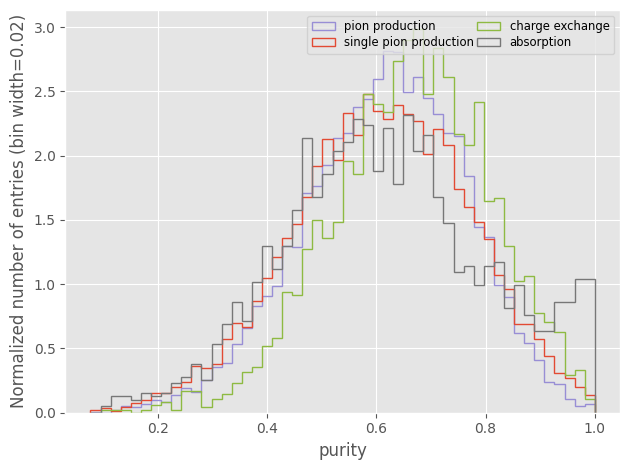

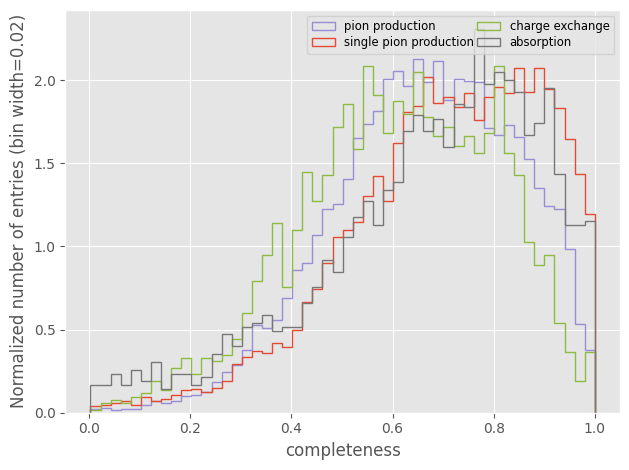

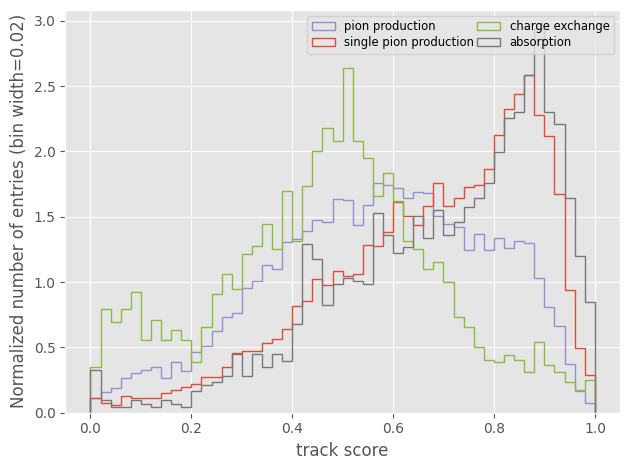

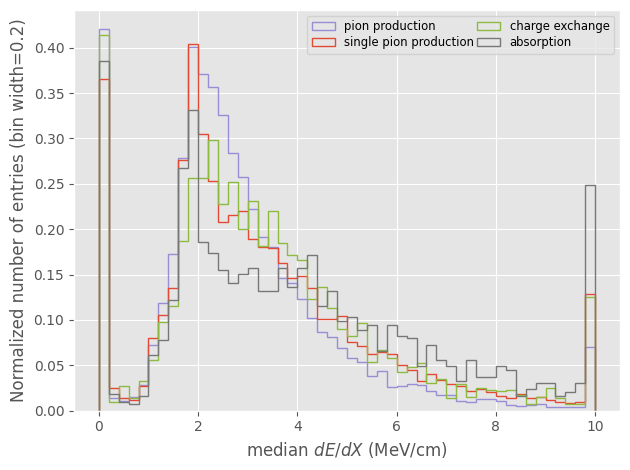

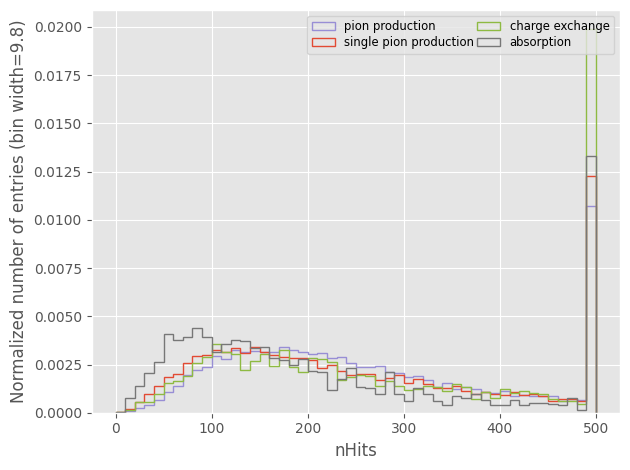

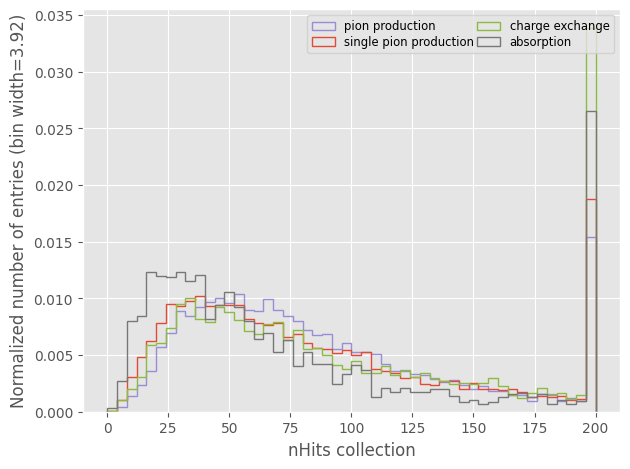

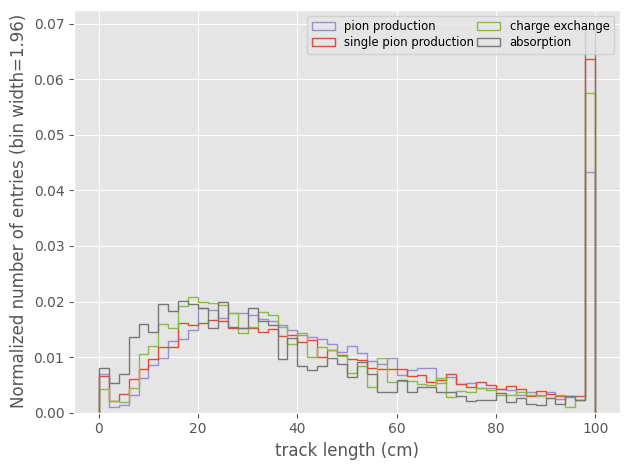

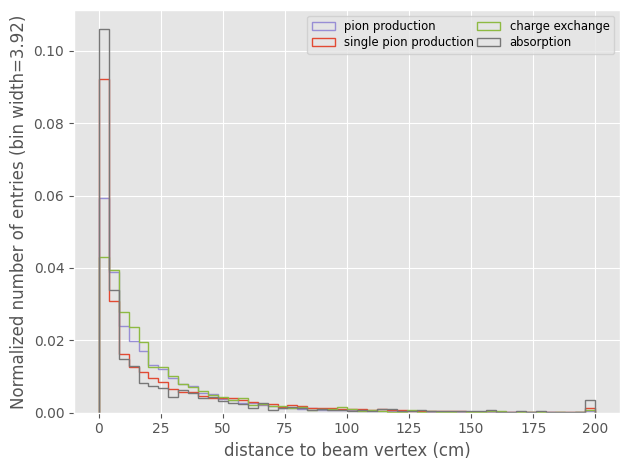

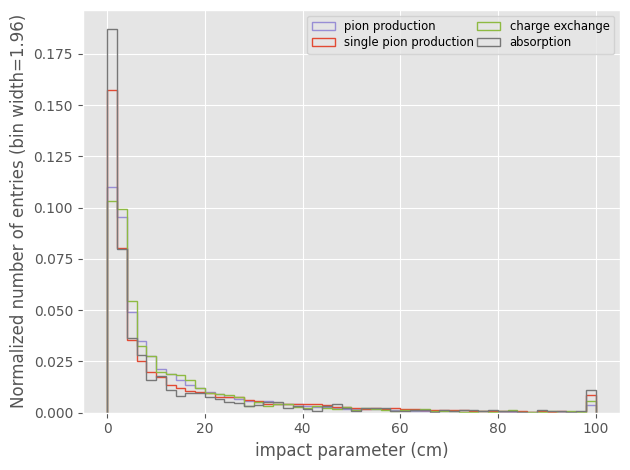

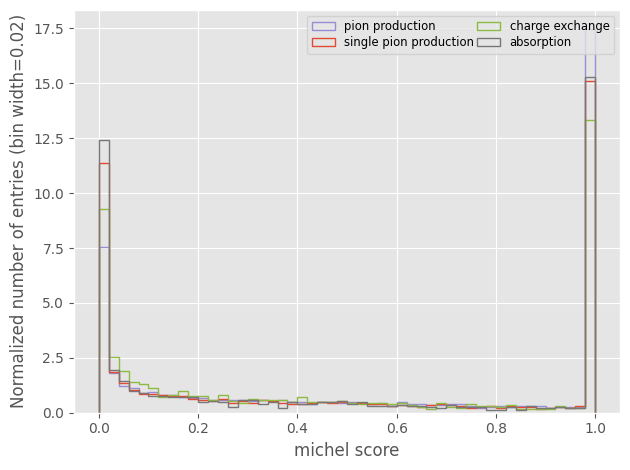

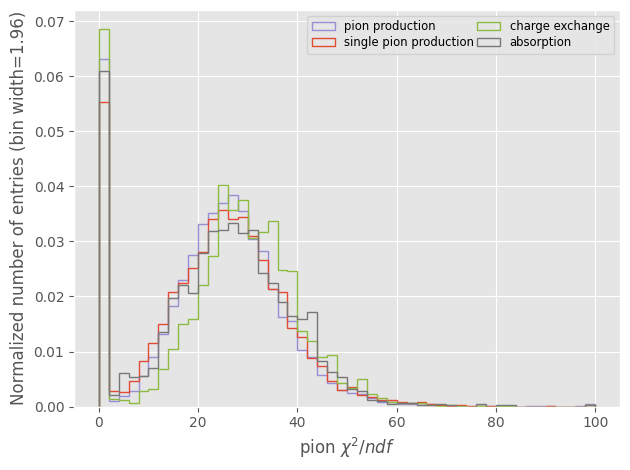

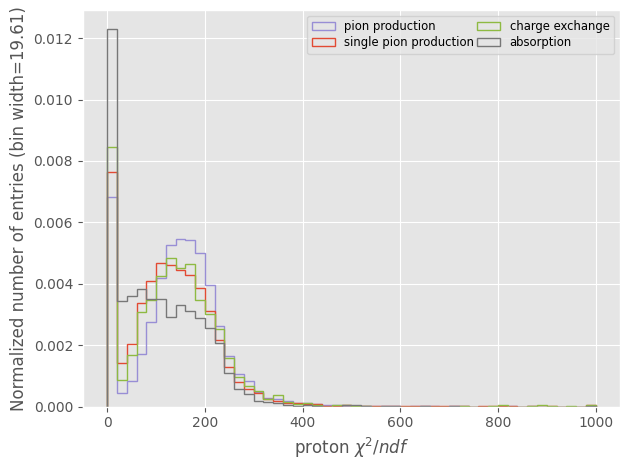

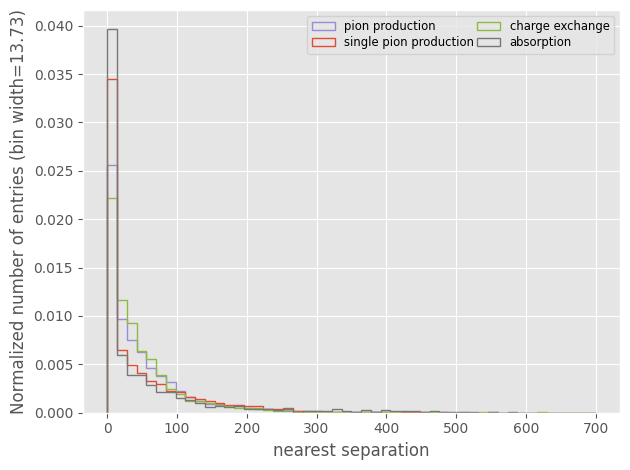

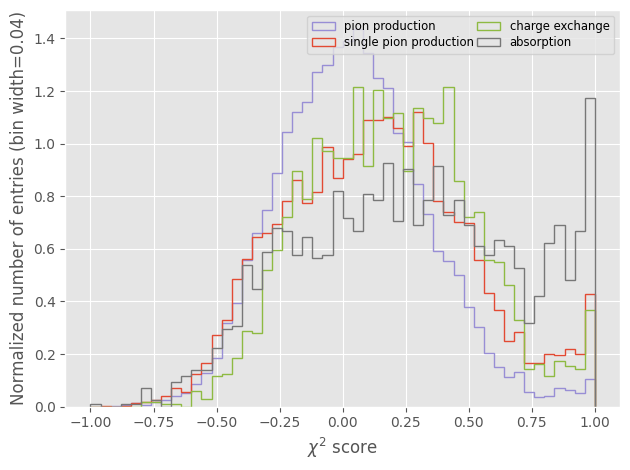

In [80]:
tags = Tags.ExclusiveProcessTags(mc_true_regions)
for (n, o), r in zip(observables.items(), ranges.values()):
    Plots.PlotTagged(ak.mean(o, axis = -1), tags, bins = 50, x_label = x_labels[n], x_range = r, truncate = r is not None, stacked = False, reverse_sort = True, histtype = "step", y_scale = "linear", norm = True)


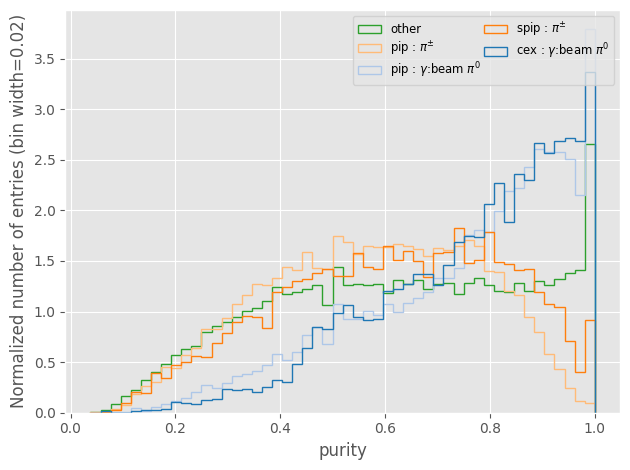

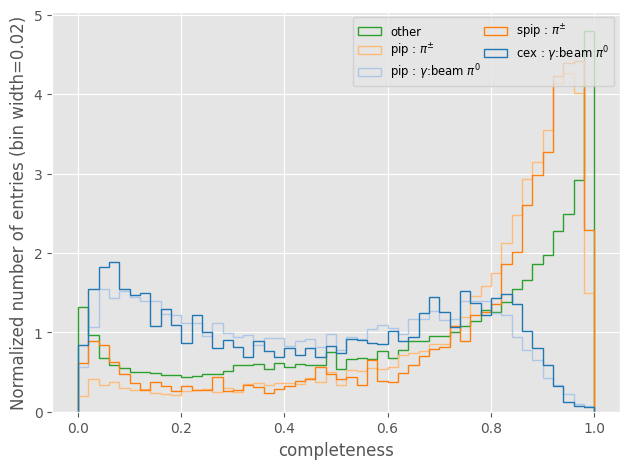

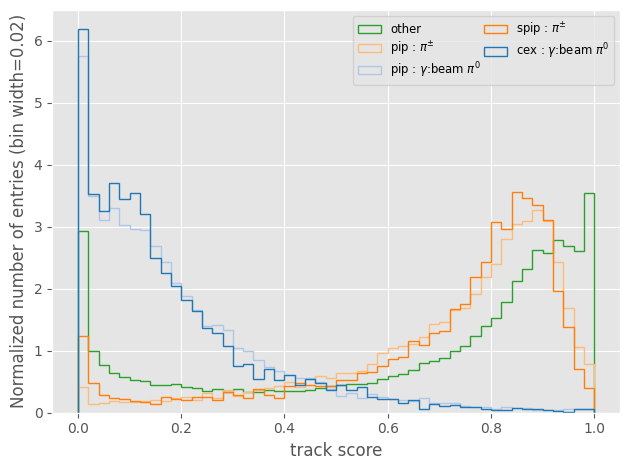

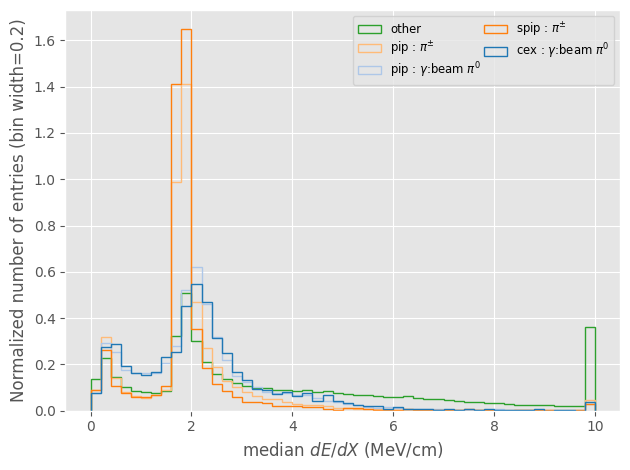

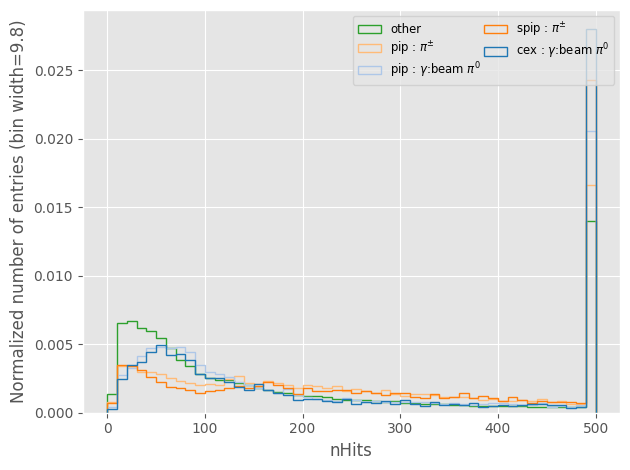

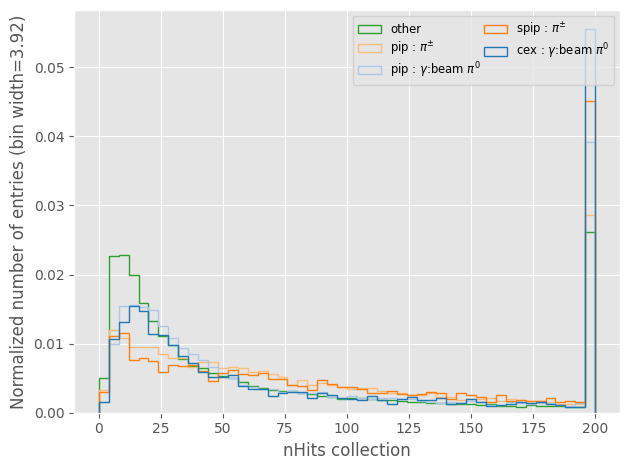

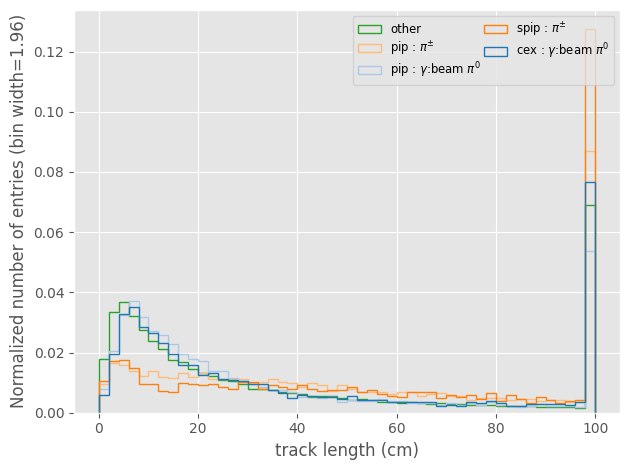

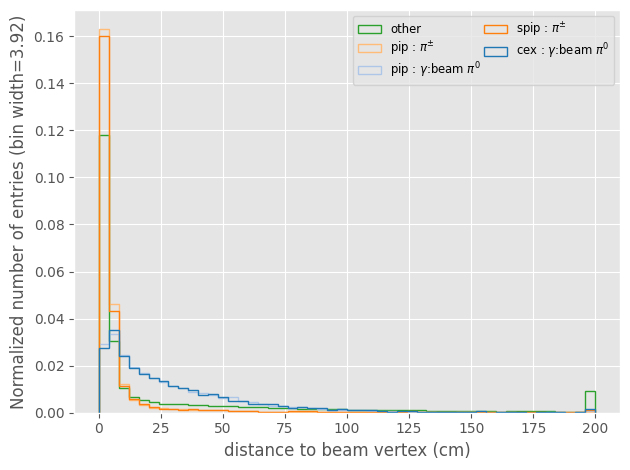

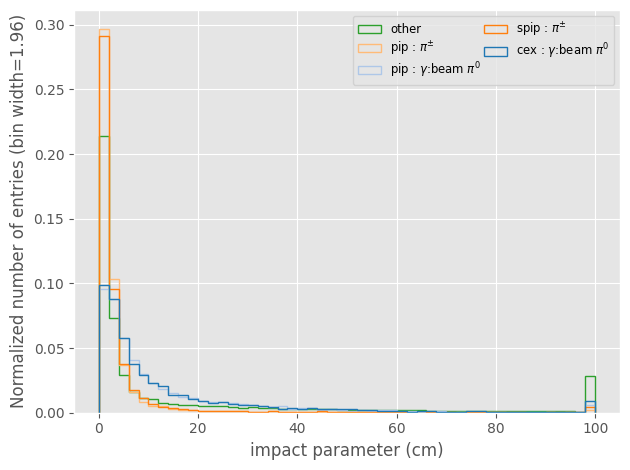

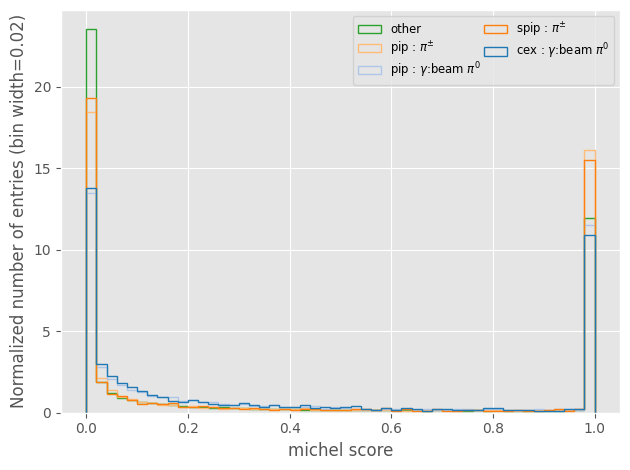

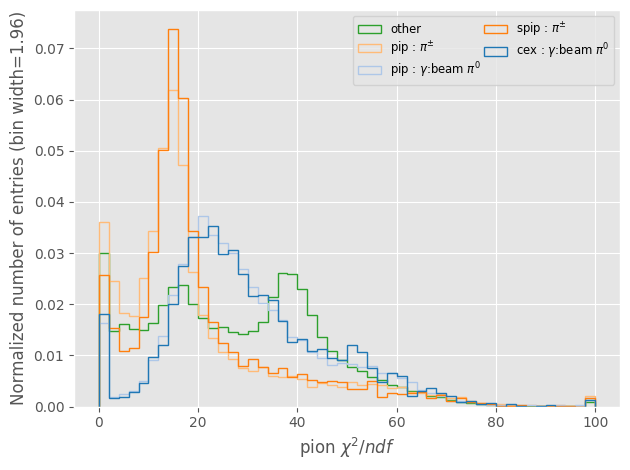

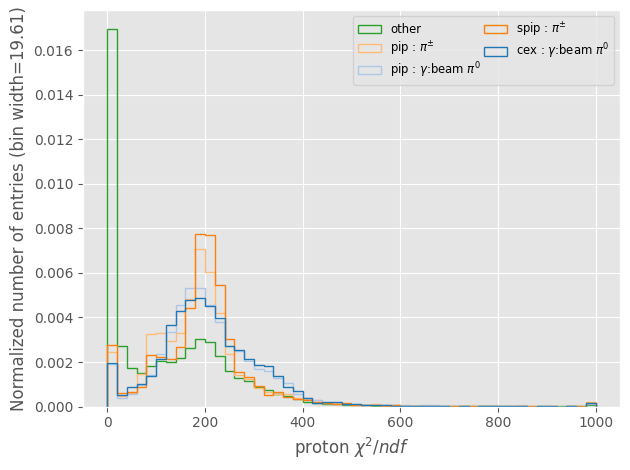

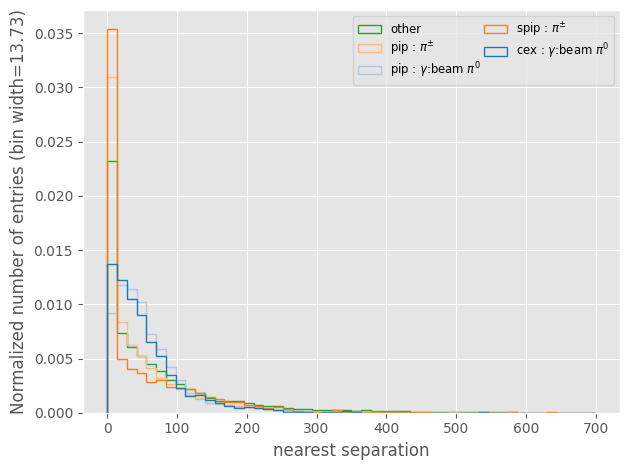

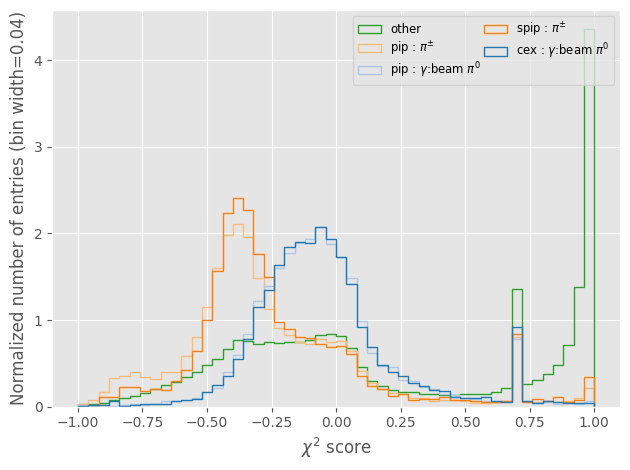

In [10]:
tags = ProcessPFOs()
for (n, o), r in zip(observables.items(), ranges.values()):
    Plots.PlotTagged(o, tags, bins = 50, x_label = x_labels[n], x_range = r, truncate = r is not None, stacked = False, reverse_sort = True, histtype = "step", y_scale = "linear", norm = True)
    # Plots.PlotTagged(observables["track_score"], Tags.ExclusiveProcessTags(mc_true_regions), bins = 50, stacked = False, reverse_sort = True, histtype = "step", norm = True)
    # book.Save()

In [41]:
tags = ProcessPFOs()

In [49]:
with Plots.PlotBook("correlation_plots.pdf", True) as book:
    for _, c in Plots.IterMultiPlot(list(itertools.product(observables.keys(), repeat = 2)), threshold = 200):
        for tag in tags.values():
            if tag.name == "other": continue
            Plots.Plot(ak.ravel(observables[c[0]][tag.mask])[:1000], ak.ravel(observables[c[1]][tag.mask])[:1000], xlabel = x_labels[c[0]], ylabel = x_labels[c[1]], color = tag.colour, linestyle = "", marker = "o", newFigure = False, label = tag.name)
    book.Save()
    Plots.plt.close()


pdf correlation_plots.pdf has been opened
pdf correlation_plots.pdf has been closed


# optimised cuts example

In [197]:
pi = tags.number[0].mask
gamma = tags.number[3].mask
p = tags.number[7].mask

In [114]:
with Plots.PlotBook("correlation_plots.pdf", True) as book:
    for _, c in Plots.IterMultiPlot(list(itertools.product(observables.keys(), repeat = 2)), threshold = 200):
        Plots.Plot(ak.ravel(observables[c[0]][mask][gamma]), ak.ravel(observables[c[1]][mask][gamma]), label = "$\gamma$", marker = "o", linestyle = "", newFigure = False, color = "C1", alpha = 0.33)
        Plots.Plot(ak.ravel(observables[c[0]][mask][p]), ak.ravel(observables[c[1]][mask][p]), label = "$p$", marker = "o", linestyle = "", newFigure = False, color = "C2", alpha = 0.33)
        Plots.Plot(ak.ravel(observables[c[0]][mask][pi]), ak.ravel(observables[c[1]][mask][pi]), label = "$\pi^{\pm}$", marker = "o", linestyle = "", newFigure = False, color = "C0", alpha = 0.33, xlabel = c[0], ylabel = c[1])
        Plots.plt.xlim(ranges[c[0]])
        Plots.plt.ylim(ranges[c[1]])
    book.Save()
    Plots.plt.close()

pdf correlation_plots.pdf has been opened
pdf correlation_plots.pdf has been closed


In [200]:
for k, v in {"pi" : pi, "p" : p, "gamma" : gamma}.items():
    with Plots.PlotBook(k) as book:
        cut_op = CutOptimiser(None, v, n_step = 25)
        for o in observables:
            cut_op.x = observables[o][mask]
            cut_op.x_range = ranges[o]
            plot = Plots.MultiPlot(2)
            next(plot)
            results = cut_op.Optimise(cut_op.pe, plot = True)
            Plots.plt.title(o)
            next(plot)
            cut_op.visualise(*results, tags = tags, x_label = o)
            book.Save()
    Plots.plt.close("all")

pdf pi.pdf has been opened


/tmp/ipykernel_42005/475216484.py:32: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


pdf pi.pdf has been closed
pdf p.pdf has been opened


/tmp/ipykernel_42005/475216484.py:32: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


pdf p.pdf has been closed
pdf gamma.pdf has been opened


/tmp/ipykernel_42005/475216484.py:32: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


pdf gamma.pdf has been closed


# Optimise Cuts

In [8]:
def CreateOptimisedSelection(x, signal, x_range, mask = None, invert = False, score : callable = CutOptimiser.pe):
    if mask is None:
        mask = np.ones_like(x, dtype = bool)
    cut_op = CutOptimiser(x[mask], signal[mask], x_range = x_range)
    cut = list(cut_op.Optimise(getattr(cut_op, score.__name__)))
    if invert:
        if cut[1] == "<":
            cut[1] = ">"
        elif cut[1] == ">":
            cut[1] = "<"
        else:
            pass
    func = SelectionTools.cuts_to_func(*cut)
    return cut, func, func(x)


def SelectionFactory(obs : list[str], target : list[ak.Array], invert : list[str], score : list[callable], original_tags, initial_mask : ak.Array = None):
    cuts = {}
    func = {}
    masks = {}
    
    if initial_mask is None:
        selected_mask = ak.ones_like(observables["track_score"], dtype = bool)
    else:
        selected_mask = initial_mask

    for o, t, i, s in zip(obs, target, invert, score):
        
        c, f, m = CreateOptimisedSelection(observables[o], t, x_range = ranges[o], mask = selected_mask, invert = i, score = s)

        if o in cuts:
            k = o+"#"
        else:
            k = o

        cuts[k], func[k], masks[k] = c, f, m
        selected_mask = selected_mask & SelectionTools.CombineMasks(masks)

    tags_new = Tags.GenerateTrueParticleTagsInterestingPFOs(mc_beam)

    for t in tags_new:
        tags_new[t].mask = tags_new[t].mask[selected_mask]

    eff = {}
    for t in original_tags:
        eff[t] = f"{ak.sum(tags_new[t].mask) / ak.sum(original_tags[t].mask):.2f}"

    print(f"{pd.DataFrame(eff, index = [0])}")

    Plots.PlotTags(tags_new, fraction = True)

    return cuts, func, masks, selected_mask

In [22]:
current_track_score_mask = args.selection_masks["mc"]["pi"]["TrackScoreCut"]
current_nHits_mask = args.selection_masks["mc"]["pi"]["NHitsCut"]

## high efficiency selection

In [9]:
original_tags = Tags.GenerateTrueParticleTagsInterestingPFOs(mc_beam)

pi = original_tags.number[0].mask
gamma = original_tags.number[3].mask
gamma_other = original_tags.number[4].mask
p = original_tags.number[7].mask
mu = original_tags.number[9].mask

In [10]:
high_purity_pions = {
    "obs" : [
        "chir_score",
        "track_score",
        "beam_dist",
        "chi2_pion",
        "median_dEdX",
        "nHits_collection",
        "chi2_pion",
        "median_dEdX",
    ],
    "target" : [
        pi,
        pi,
        mu,
        p,
        p,
        p,
        p,
        pi,
    ],
    "invert" : [
        False,
        False,
        True,
        True,
        True,
        True,
        True,
        False,

    ],
    "score" : [
        CutOptimiser.pe,
        CutOptimiser.pe,
        CutOptimiser.pe,
        CutOptimiser.p,
        CutOptimiser.p,
        CutOptimiser.p,
        CutOptimiser.p,
        CutOptimiser.pe,
    ],
}


high_efficiency_photons = {
    "obs" : [
        "chi2_proton",
        "track_score",
        "nHits",
        "beam_dist",
        "beam_ip",
    ],
    "target" : [
        gamma,
        gamma,
        gamma,
        gamma,
        gamma,
    ],
    "invert" : [
        False,
        False,
        False,
        False,
        False,
    ],
    "score" : [
        CutOptimiser.pe,
        CutOptimiser.pe,
        CutOptimiser.pe,
        CutOptimiser.pe,
        CutOptimiser.pe,
    ],
}



high_efficiency_pions = {
    "obs" : [
        "chi2_proton",
        "track_score",
        "median_dEdX",
    ],
    "target" : [
        pi,
        pi,
        p,
    ],
    "invert" : [
        False,
        False,
        True,
    ],
    "score" : [
        CutOptimiser.pe,
        CutOptimiser.pe,
        CutOptimiser.p,
    ],
}

In [ ]:


beam_PFO_cuts, beam_PFO_funcs, beam_PFO_masks, selected_mask = SelectionFactory(
    [
        "chi2_score",
        "chi2_score",
        # "track_score",
        # "nHits",
        # "beam_dist",
        # "beam_ip",
    ],
    [
        gamma,
        pi,
        # gamma,
        # gamma,
        # gamma,
    ],
    [
        False,
        False,
        # False,
        # False,
        # False,
    ],
    [
        CutOptimiser.pe,
        CutOptimiser.pe,
        # CutOptimiser.pe,
        # CutOptimiser.pe,
        # CutOptimiser.pe,
    ],
    original_tags,
    None,
)


_, _, _, selected_mask = SelectionFactory(
    **high_efficiency_photons,
    original_tags = original_tags,
    initial_mask = None,
)

# pion_cuts, pion_funcs, pion_masks, selected_mask = SelectionFactory(
#     **high_efficiency_pions,
#     original_tags = original_tags,
#     initial_mask = None,
# )


tags = Tags.GenerateTrueParticleTagsInterestingPFOs(mc_beam)

for t in tags:
    tags[t].mask = tags[t].mask[selected_mask]

cut_op = CutOptimiser(None, gamma[selected_mask])
for o in observables:
    cut_op.x = observables[o][selected_mask]
    cut_op.x_range = ranges[o]
    plot = Plots.MultiPlot(2)
    next(plot)
    results = cut_op.Optimise(cut_op.pe, plot = True)
    next(plot)
    cut_op.visualise(*results, tags = tags, x_label = o)

/tmp/ipykernel_41815/3120342744.py:106: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


$\pi^{\pm}$ $\pi^{\pm}$:2nd $\gamma$:2nd $\gamma$:beam $\pi^0$  \
0        0.08            0.14         0.18                  0.79   

  $\gamma$:other $\pi^0$ $e^{-}$ $e^{+}$   $p$ other $\mu^{\pm}$  
0                   0.71    0.41    0.49  0.02  0.01        0.08

/tmp/ipykernel_41815/3120342744.py:106: RuntimeWarning: invalid value encountered in long_scalars
  return ak.sum(selected_signal)/ak.count(selected_signal)


$\pi^{\pm}$ $\pi^{\pm}$:2nd $\gamma$:2nd $\gamma$:beam $\pi^0$  \
0        0.83            0.71         0.10                  0.11   

  $\gamma$:other $\pi^0$ $e^{-}$ $e^{+}$   $p$ other $\mu^{\pm}$  
0                   0.13    0.11    0.15  0.25  0.26        0.73

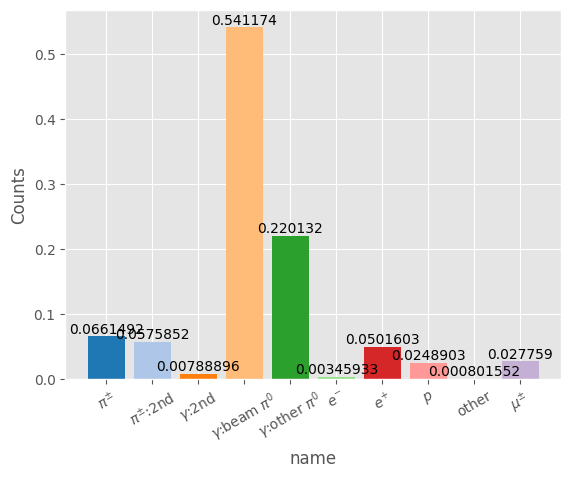

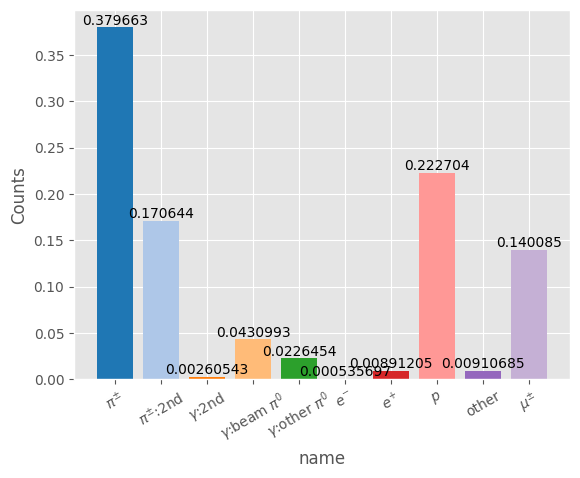

In [183]:
loose_photon_selection = SelectionFactory(**high_efficiency_photons, original_tags = original_tags)
loose_pion_selection = SelectionFactory(**high_efficiency_pions, original_tags = original_tags)

In [15]:
def MaskTags(tags, mask):
    for t in tags:
        if tags[t].mask is not None:
            tags[t].mask = tags[t].mask & mask
    return

def CutTags(tags, mask):
    for t in tags:
        if tags[t].mask is not None:
            tags[t].mask = tags[t].mask[mask]
    return


In [16]:
def PerformanceTables(selection, region):
    tags = Tags.GenerateTrueParticleTagsInterestingPFOs(mc_beam)

    if region is not None:
        CutTags(tags, region)

    purity = {}
    efficiency = {}
    counts = {}


    mask = region[region] if region is not None else None
    for k, v in selection[2].items():
        p = {}
        e = {}
        c = {}
        for t in tags:
            p[t], e[t], c[t] = pec(mask, tags[t].mask)
        purity[k] = p
        efficiency[k] = e
        counts[k] = c
        if mask is None:
            mask = v[region] if region is not None else v
        else:
            mask = mask & (v[region] if region is not None else v)
    c = {k : cross_section.remove_(k) for k in selection[2]}
    return {"efficiency" : 100 * pd.DataFrame(efficiency).rename(columns = c).T, "purity" : 100 * pd.DataFrame(purity).rename(columns = c).T, "counts" : pd.DataFrame(counts).rename(columns = c).T}

def PlotSelectionInRegion(selection, region, yscale = "linear", book = Plots.PlotBook.null):
    mask = region
    for k, v in selection[2].items():
        tags = Tags.GenerateTrueParticleTagsInterestingPFOs(mc_beam)
        MaskTags(tags, mask)
        Plots.PlotTagged(observables[k], tags, x_range = ranges[k], truncate = True if ranges[k] is not None else False, y_scale = yscale, x_label = x_labels[k])
        if ranges[k] is None:
            l = ak.max(observables[k])
        else:
            l = max(ranges[k])
        Plots.DrawCutPosition(selection[0][k][0], face = selection[0][k][1], arrow_length = 0.1 * l)
        if mask is None:
            mask = v
        else:
            mask = mask & v
        book.Save()

    selected_mask = SelectionTools.CombineMasks(selection[2])

    tags = Tags.GenerateTrueParticleTagsInterestingPFOs(mc_beam)
    MaskTags(tags, region & selected_mask)

    Plots.PlotTags(tags, "particle species", fraction = False)
    book.Save()

    for _, p in Plots.IterMultiPlot(mc_true_regions):
        
        tags = Tags.GenerateTrueParticleTagsInterestingPFOs(mc_beam)
        for t in tags:
            tags[t].mask = tags[t].mask & mc_true_regions[p] & region
            tags[t].mask = tags[t].mask[selected_mask]

        Plots.PlotTags(tags, xlabel = cross_section.remove_(p), newFigure = False, fraction= False)
        Plots.plt.tight_layout()
    book.Save()

def SelectionResults(selection, region, dir = None):
    tables_all = PerformanceTables(selection, None)
    tables_region = PerformanceTables(selection, region)
    if dir:
        cross_section.os.makedirs(dir, exist_ok = True)
    for k, v in tables_all.items():
        v.style.format(precision = 2).to_latex(dir + k + "_all.tex")
    for k, v in tables_region.items():
        v.style.format(precision = 2).to_latex(dir + k + "_region.tex")

    with Plots.PlotBook(dir + "plots.pdf", dir is not None) as book:
        PlotSelectionInRegion(selection, region, "linear", book)
    with Plots.PlotBook(dir + "log_plots.pdf", dir is not None) as book:
        PlotSelectionInRegion(selection, region, "log", book)
    return


In [23]:
SelectionResults(loose_photon_selection, mc_reco_regions["single_pion_production"], "test/loose_photon_selection_spip/")
Plots.plt.close("all")

SelectionResults(loose_pion_selection, mc_reco_regions["single_pion_production"], "test/loose_pion_selection_spip/")
Plots.plt.close("all")

pdf test/loose_photon_selection_spip/plots.pdf has been opened
pdf test/loose_photon_selection_spip/plots.pdf has been closed
pdf test/loose_photon_selection_spip/log_plots.pdf has been opened
pdf test/loose_photon_selection_spip/log_plots.pdf has been closed
pdf test/loose_pion_selection_spip/plots.pdf has been opened
pdf test/loose_pion_selection_spip/plots.pdf has been closed
pdf test/loose_pion_selection_spip/log_plots.pdf has been opened
pdf test/loose_pion_selection_spip/log_plots.pdf has been closed


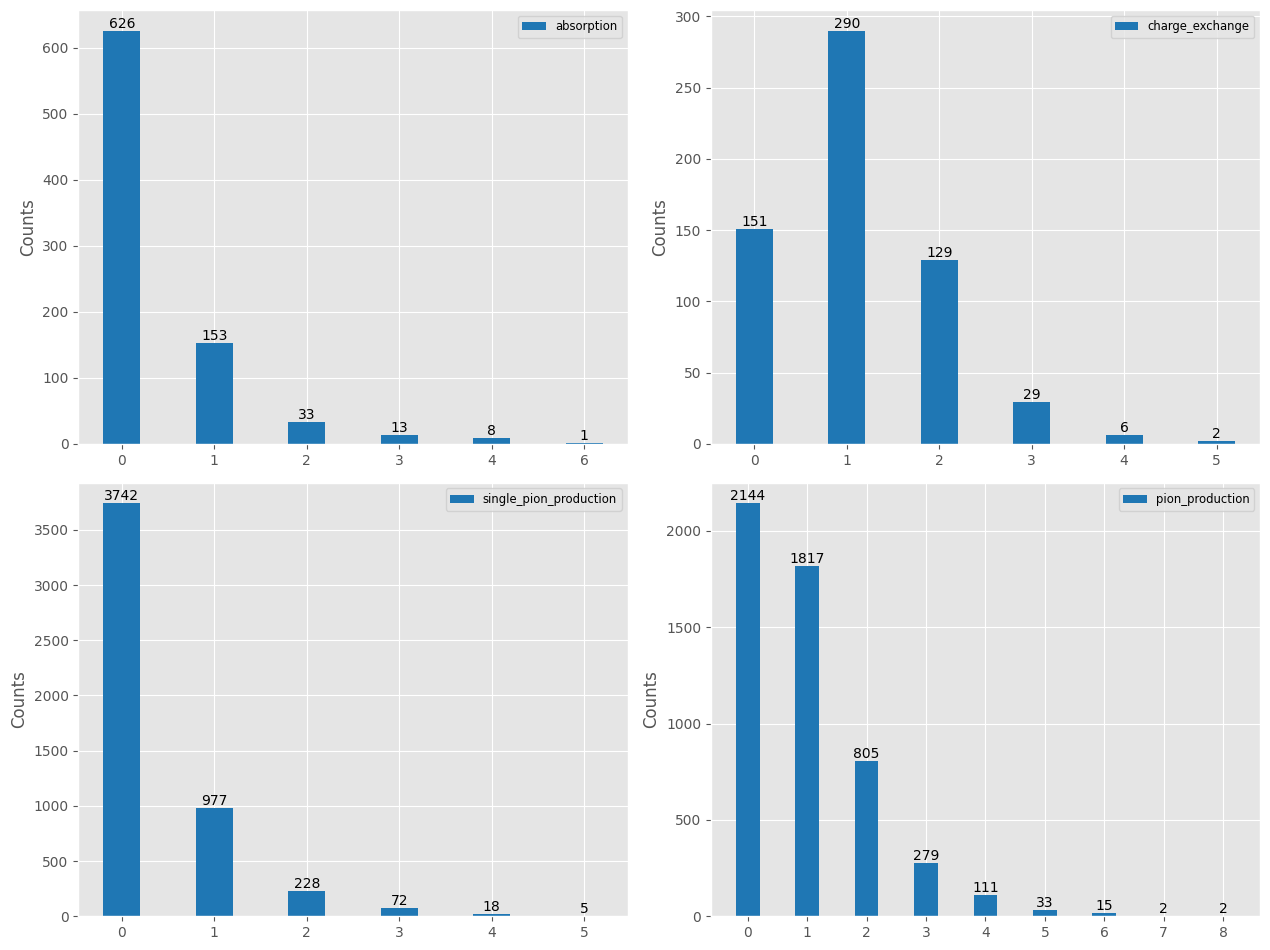

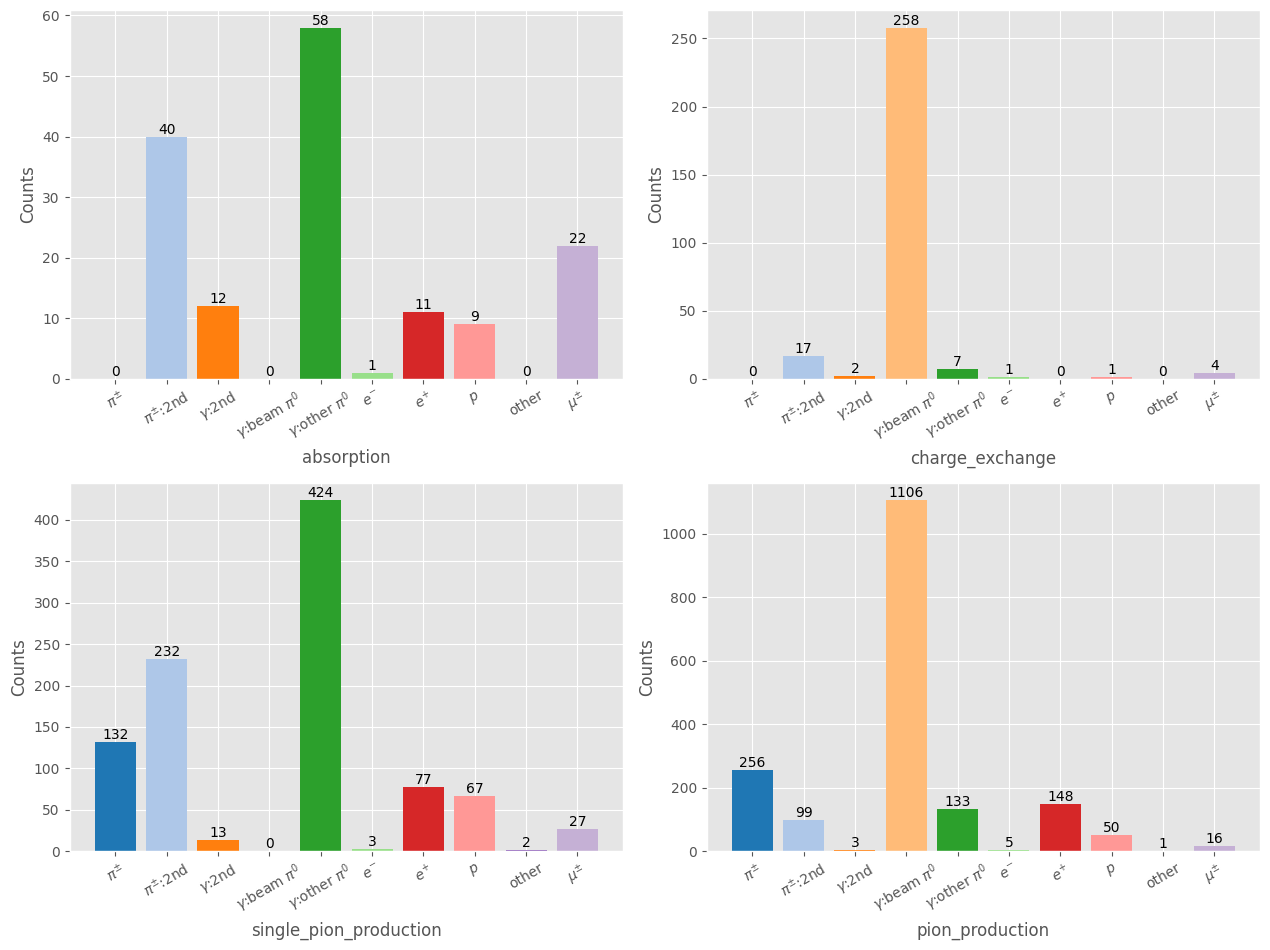

In [17]:
selected_mask = SelectionTools.CombineMasks(loose_photon_selection[2])

for _, p in Plots.IterMultiPlot(mc_true_regions):
    Plots.PlotBar(ak.sum(selected_mask[mc_true_regions[p] & mc_reco_regions["single_pion_production"]], -1), label = p, newFigure = False)


for _, p in Plots.IterMultiPlot(mc_true_regions):
    
    tags = Tags.GenerateTrueParticleTagsInterestingPFOs(mc_beam)
    for t in tags:
        tags[t].mask = tags[t].mask & mc_true_regions[p] & mc_reco_regions["single_pion_production"]
        tags[t].mask = tags[t].mask & (ak.sum(selected_mask, -1) == 1)
        tags[t].mask = tags[t].mask[selected_mask]

    Plots.PlotTags(tags, xlabel = p, newFigure = False, fraction= False)
    Plots.plt.tight_layout()
    # Plots.PlotBar(ak.sum(selected_mask[mc_true_regions[p] & mc_reco_regions["absorption"]], -1), label = p, newFigure = False)

pdf test/selection_matrix_cex.pdf has been opened
pdf test/selection_matrix_cex.pdf has been closed


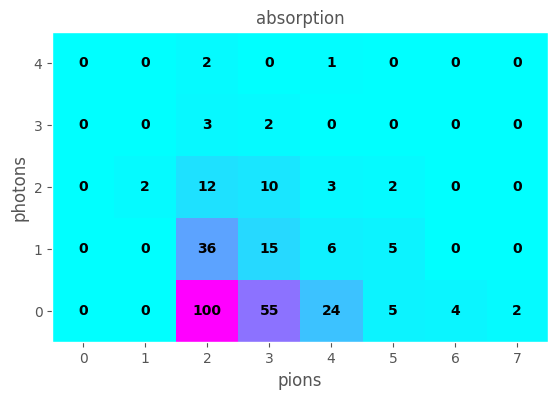

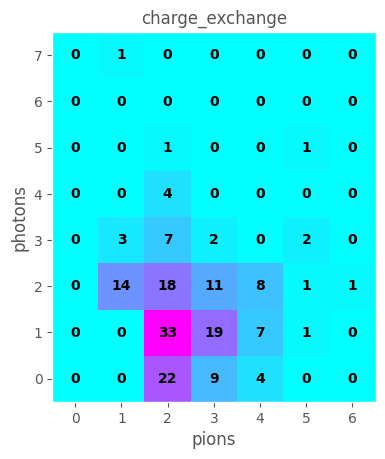

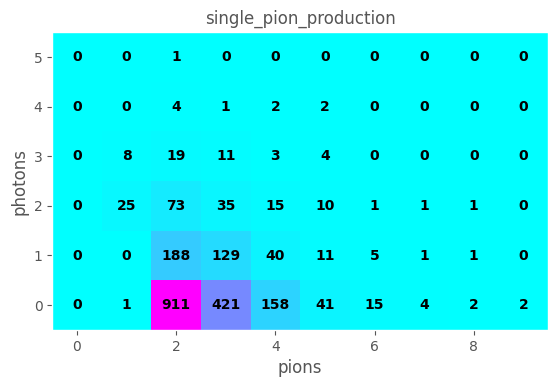

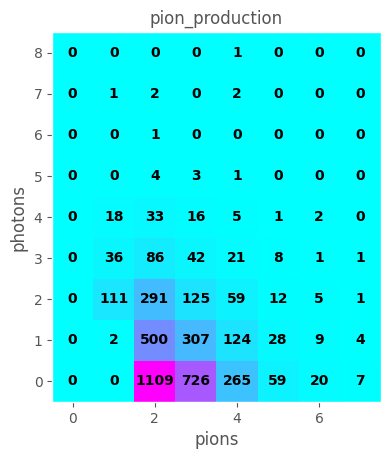

In [54]:
loose_photon_mask = SelectionTools.CombineMasks(loose_photon_selection[2])
loose_pion_mask = SelectionTools.CombineMasks(loose_pion_selection[2])


loose_photon_count = ak.sum(loose_photon_mask, -1)
loose_pion_count = ak.sum(loose_pion_mask, -1)

pion_photon_count = ak.sum(loose_photon_mask & loose_pion_mask, -1)

with Plots.PlotBook("test/selection_matrix_cex.pdf", True) as book:
    for t in mc_true_regions:
        PlotMat(CreateMatrix(loose_photon_count[mc_reco_regions["pion_production"] & mc_true_regions[t]], loose_pion_count[mc_reco_regions["pion_production"] & mc_true_regions[t]]), "pions", "photons", title = t)
        book.Save()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:890: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


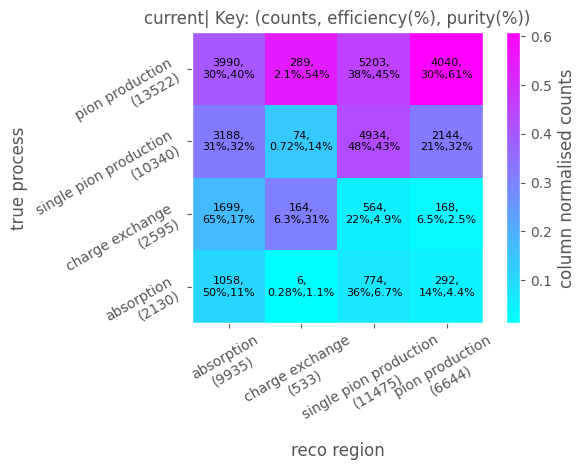

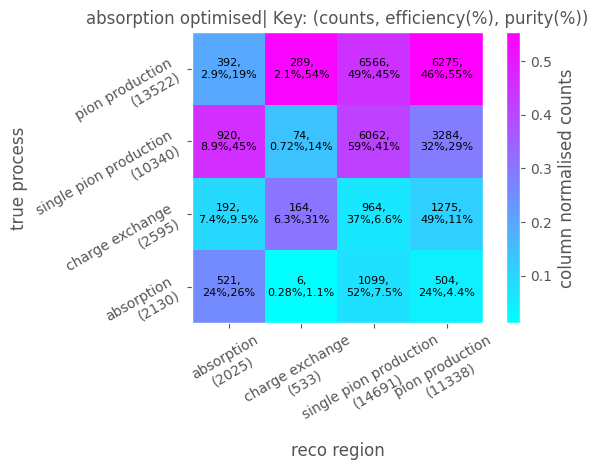

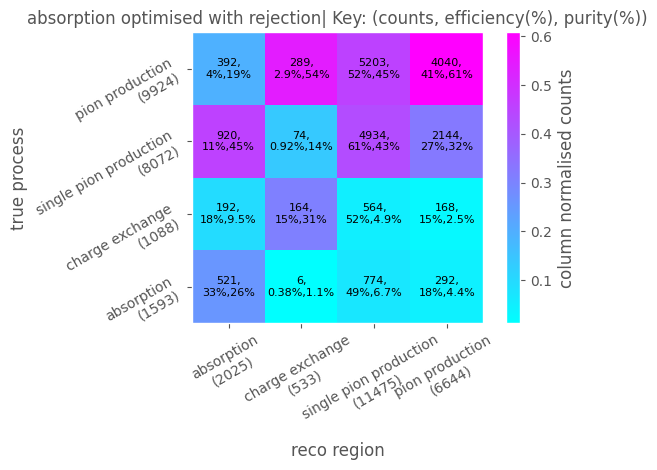

In [186]:
def loose_particle_selection_abs(current_regions, n_l_photons, n_l_pions):
    regions = {k : v for k,v in current_regions.items()}

    regions["single_pion_production"] = regions["single_pion_production"] | (regions["absorption"] & (n_l_pions == 1))

    # regions["charge_exchange"] = regions["charge_exchange"] | (regions["absorption"] & (n_l_photons == 1) & (n_l_pions == 0))
    # regions["charge_exchange"] = regions["charge_exchange"] | (regions["absorption"] & (n_l_photons == 1) & (n_l_pions == 0))
    regions["pion_production"] = regions["pion_production"] | (regions["absorption"] & ((n_l_pions > 1) | ((n_l_photons > 0) & (n_l_pions == 0))) )

    regions["absorption"] = regions["absorption"] & (n_l_photons == 0) & (n_l_pions == 0)
    return regions

def loose_particle_selection_spip(current_regions, n_l_photons, n_l_pions, n_photons):
    regions = {k : v for k,v in current_regions.items()}
    regions["pion_production"] = regions["pion_production"] | (regions["single_pion_production"] & (n_photons == 0) & (n_l_photons > 0) & (n_l_pions > 0))

    regions["single_pion_production"] = regions["single_pion_production"] & (n_photons == 0) & (n_l_photons == 0) & (n_l_pions == 1)
    return regions


def loose_particle_selection_rejection_abs(current_regions, n_l_photons, n_l_pions):
    regions = {k : v for k,v in current_regions.items()}
    regions["absorption"] = regions["absorption"] & (n_l_photons == 0) & (n_l_pions == 0)
    return regions

def loose_particle_selection_rejection_spip(current_regions, n_l_photons, n_l_pions, n_photons):
    regions = {k : v for k,v in current_regions.items()}
    regions["single_pion_production"] = regions["single_pion_production"] & (n_photons == 0) & (n_l_photons == 0) & (n_l_pions == 1)
    return regions

def loose_particle_selection_beam_PFO(n_l_beam_PFO):
    regions = {k : v for k,v in mc_reco_regions.items()}
    regions["absorption"] = regions["absorption"] & (n_l_beam_PFO == 0)
    return regions

def simple_region_selection(n_photons, n_pi):
    return {
        "absorption": np.logical_and(n_photons==0, n_pi==0),
        "charge_exchange": (n_photons == 1) & (n_pi==0),
        "single_pion_production": np.logical_and(n_photons==0, n_pi==1),
        "pion_production": ((n_photons >= 0) & (n_pi > 1)) | ((n_photons > 1) & (n_pi >= 0)) | ((n_photons == 1) & (n_pi == 1)),
    }

mc_reco_regions_alt = loose_particle_selection_abs(mc_reco_regions, loose_photon_count, loose_pion_count)


# with Plots.PlotBook("test/spip_optimisation.pdf", False) as book:
#     PlotRegionConfusionMatrix(mc_reco_regions, mc_true_regions, "current")
#     book.Save()
#     PlotRegionConfusionMatrix(loose_particle_selection_spip(mc_reco_regions, loose_photon_count, loose_pion_count, mc_region_properties["n_photon"]), mc_true_regions, "spip optimised")
#     book.Save()
#     PlotRegionConfusionMatrix(loose_particle_selection_rejection_spip(mc_reco_regions, loose_photon_count, loose_pion_count, mc_region_properties["n_photon"]), mc_true_regions, "spip optimised with rejection")


with Plots.PlotBook("test/absorption_optimisation.pdf", False) as book:
    PlotRegionConfusionMatrix(mc_reco_regions, mc_true_regions, "current")
    book.Save()
    PlotRegionConfusionMatrix(mc_reco_regions_alt, mc_true_regions, "absorption optimised")
    book.Save()
    PlotRegionConfusionMatrix(loose_particle_selection_rejection_abs(mc_reco_regions, loose_photon_count, loose_pion_count), mc_true_regions, "absorption optimised with rejection")

# PlotRegionConfusionMatrix(simple_region_selection(mc_region_properties["n_photon"], mc_region_properties["n_pi"]), mc_true_regions, "simple")


In [135]:
for r in mc_reco_regions_alt:
    for t in mc_true_regions:
        MCParticleTopologies(mc_beam, mc_particle_masks, bt_mc_particle_masks, mc_region_properties, r, t, "test/particle_tables_new", regions, mc_true_regions)
        clear_output()

for f in [cross_section.os.path.join(dp, f) for dp, dn, fn in cross_section.os.walk(cross_section.os.path.expanduser("test/particle_tables_new")) for f in fn]:
    FormatTable(f)

# confusion matrices

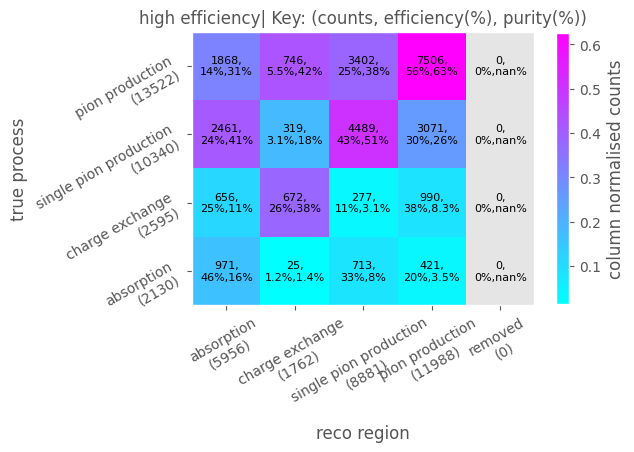

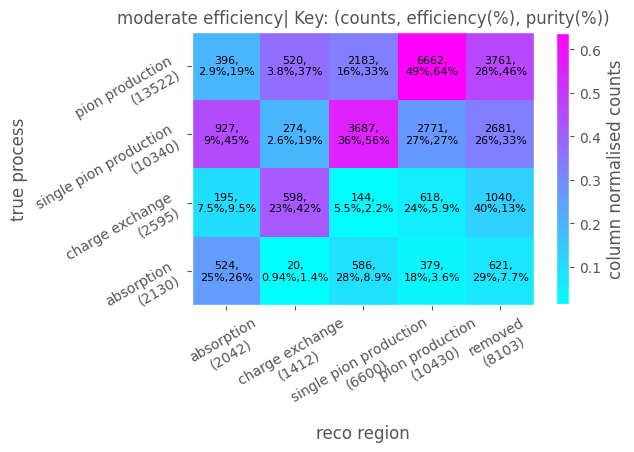

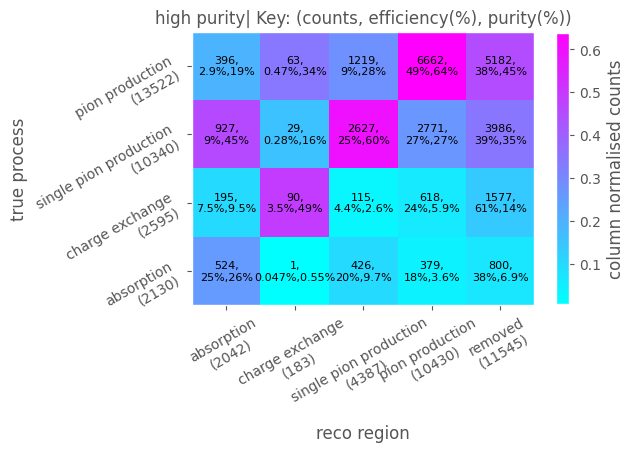

In [9]:
counts = {k: v for k, v in mc_region_properties.items() if "_mask" not in k}

with Plots.PlotBook("optimised_idetification", False) as book:
    # PlotRegionConfusionMatrix(mc_reco_regions, mc_true_regions)
    # book.Save()
    PlotRegionConfusionMatrix(RegionIdentification.CreateRegionIdentification(RegionIdentification.regions["high_efficiency"], **counts, removed = True), mc_true_regions, "high efficiency")
    book.Save()
    PlotRegionConfusionMatrix(RegionIdentification.CreateRegionIdentification(RegionIdentification.regions["moderate_efficiency"], **counts, removed = True), mc_true_regions, "moderate efficiency")
    book.Save()
    PlotRegionConfusionMatrix(RegionIdentification.CreateRegionIdentification(RegionIdentification.regions["high_purity"], **counts, removed = True), mc_true_regions, "high purity")
    book.Save()

In [51]:
mats = {}
for r in RegionIdentification.regions:
    mats[r] = np.array(cross_section.CountInRegions(mc_true_regions, RegionIdentification.CreateRegionIdentification(RegionIdentification.regions[r], **counts, removed = True)))

In [55]:
mats["default"][:, :-1]

array([[1058,    6,  774,  292],
       [1699,  164,  564,  168],
       [3188,   74, 4934, 2144],
       [3990,  289, 5203, 4040]])

In [60]:
sb = {}
for r in mats:
    sb[r] = np.diag(mats[r]) / (np.sum(mats[r], 0)[:-1] - np.diag(mats[r]))**0.5
print(sb)

print([np.sum(sb[r]) for r in sb])

pe = {}
for r in mats:
    pe[r] = (np.diag(mats[r]) / np.sum(mats[r], 0)[:-1]) * (np.diag(mats[r]) / np.sum(mats[r], 1))

print(pe)

print([np.sum(pe[r]) for r in pe])


pe_removed = {}
for r in mats:
    pe_removed[r] = (np.diag(mats[r]) / np.sum(mats[r], 0)[:-1]) * (np.diag(mats[r]) / np.sum(mats[r][:, :-1], 1))

print(pe_removed)

print([np.sum(pe_removed[r]) for r in pe_removed])


{
    'high_purity': array([ 13.44916746,   9.33256525,  62.61865555, 108.52984463]),
    'high_efficiency': array([ 13.75265817,  20.3542931 ,  67.73582733, 112.11730088]),
    'moderate_efficiency': array([ 13.44916746,  20.95988915,  68.31292722, 108.52984463]),
    'default': array([11.22929672,  8.53749898, 61.00663496, 79.17004197])
}

[193.93023289629542, 213.96007948634642, 211.25182846353295, 159.9434726350637]

{
    'high_purity': array([0.06312876, 0.01705676, 0.15213599, 0.31469078]),
    'high_efficiency': array([0.07431974, 0.09876323, 0.21944051, 0.34755973]),
    'moderate_efficiency': array([0.06312876, 0.09759562, 0.19919654, 0.31469078]),
    'default': array([0.05289613, 0.01944568, 0.20517529, 0.18167375])
}

[0.5470122883512996, 0.7400832079023412, 0.6746116952624, 0.45919084304522517]

{
    'high_purity': array([0.10110094, 0.04347966, 0.24757415, 0.51022167]),
    'high_efficiency': array([0.07431974, 0.09876323, 0.21944051, 0.34755973]),
    'moderate_efficiency': array([0.08910818, 0.16286857, 0.26892444, 0.43594393]),
    'default': array([0.05289613, 0.01944568, 0.20517529, 0.18167375])
}

[0.9023764212199006, 0.7400832079023412, 0.9568451214849873, 0.45919084304522517]

In [37]:
cross_section.ReadHDF5("work/2023/region_identification/region_performance_average/norm_test_high_eff/results_fmt.hdf5").style.to_latex("work/2023/region_identification/region_performance_average/norm_test_high_eff.tex")
cross_section.ReadHDF5("work/2023/region_identification/region_performance_average/norm_test_mid_eff/results_fmt.hdf5").style.to_latex("work/2023/region_identification/region_performance_average/norm_test_mid_eff.tex")
cross_section.ReadHDF5("work/2023/region_identification/region_performance_average/norm_test_high_pur/results_fmt.hdf5").style.to_latex("work/2023/region_identification/region_performance_average/norm_test_high_pur.tex")


for f in cross_section.ls_recursive("work/2023/region_identification/region_performance_average/"):
    if ".tex" in f:
        FormatTable(f)


# confusion matrix performance

In [ ]:
def RegionFractions(reco_regions, true_regions, path = None):
    counts = cross_section.CountInRegions(true_regions, reco_regions)
    fractions_df = counts / np.sum(counts, axis = 1)[:, np.newaxis]
    fractions_df = pd.DataFrame(np.array(fractions_df).T, columns = true_regions, index = reco_regions)# columns are the true regions, so index over those to get the fractions
    if path is None:
        return fractions_df
    else:
        fractions_df.to_hdf(f"{path}region_fractions.hdf5", "df")
        return

RegionFractions(RegionIdentification.CreateRegionIdentification(RegionIdentification.regions["high_efficiency"], **counts, removed = True), mc_true_regions, "test/region_performance/high_eff_")
RegionFractions(RegionIdentification.CreateRegionIdentification(RegionIdentification.regions["moderate_efficiency"].moderate_efficiency_regions, **counts, removed = True), mc_true_regions, "test/region_performance/mid_eff_")
RegionFractions(RegionIdentification.CreateRegionIdentification(RegionIdentification.regions["high_purity"].high_purity_regions, **counts, removed = True), mc_true_regions, "test/region_performance/high_pur_")


In [49]:
def CreateToyConfig(toy_params_dir : str, args):
    #! move to run_analysis.py to automatically make toy configs
    abs_path = cross_section.os.path.abspath(toy_params_dir)
    cfg = {
        'events': 1000000,
        'step': 2,
        'p_init': args.beam_momentum,
        'beam_profile': f'{abs_path}/beam_profile/beam_profile.json',
        'beam_width': 60,
        'smearing_params': {
            'KE_init': f"{abs_path}/smearing/KE_init/double_crystal_ball.json",
            'KE_int': f'{abs_path}/smearing/KE_int/double_crystal_ball.json',
            'z_int': f'{abs_path}/smearing/z_int/double_crystal_ball.json'
        },
        'reco_region_fractions': f'{abs_path}/reco_regions/reco_region_fractions.hdf5',
        'beam_selection_efficiencies': f'{abs_path}/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5',
        'mean_track_score_kde': f'{abs_path}/meanTrackScoreKDE/kdes.dill',
        'pdf_scale_factors': None,
        'df_format': 'f',
        'modified_PDFs': None,
        'verbose': True,
        'seed': 1337,
        'max_cpus': 11
    }
    return cfg


# cfg = CreateToyConfig("work/2023/analysis_2GeV_new_pfo_selection/toy_parameters", args)
for f in cross_section.ls_recursive("test/region_performance/region_fractions/"):
    cfg = CreateToyConfig("work/2023/analysis_2GeV_new_pfo_selection/toy_parameters", args)
    cfg["reco_region_fractions"] = cross_section.os.path.abspath(f)
    name = f.split("/")[-1].split("_region_fractions")[0]
    cross_section.SaveConfiguration(cfg, f"test/region_performance/toy_configs/{name}.json")

In [12]:
from apps.cex_toy_generator import GenerateRecoRegions

def GetRegions(region_fractions : str):
    masks = GenerateRecoRegions(toy_template.exclusive_process, cross_section.ReadHDF5(region_fractions), np.random.default_rng())
    regions = masks.filter(regex = "reco_regions_")
    new_col_names = {}
    for i in regions:
        new_col_names[i] = i.split("reco_regions_")[1]
    regions = regions.rename(columns = new_col_names)
    return {k : v.values for k, v in regions.items()}

toy_template = cross_section.ReadHDF5("work/2023/region_identification/region_performance/toy_template_cb_2cm.hdf5")
toy_template_ai = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(df = toy_template))

In [20]:
from apps.cex_fit_studies import NormalisationTest, PredictedCountsSummary, CreateSummaryTables, PlotCrossCheckResults, CalculateResultsFromFile

region_fractions = {
    "high_eff" : "work/2023/region_identification/region_performance/region_fractions/high_eff_region_fractions.hdf5",
    "mid_eff" : "work/2023/region_identification/region_performance/region_fractions/mid_eff_region_fractions.hdf5",
    "high_pur" : "work/2023/region_identification/region_performance/region_fractions/high_pur_region_fractions.hdf5"
}
toy_configs = {
    "high_eff" : "work/2023/region_identification/region_performance/toy_configs/high_eff.json",
    "mid_eff" : "work/2023/region_identification/region_performance/toy_configs/mid_eff.json",
    "high_pur" : "work/2023/region_identification/region_performance/toy_configs/high_pur.json"
}

In [ ]:
dire = "test/region_performance_res_2"
for k in region_fractions:
    toy_template_ai.regions = GetRegions(region_fractions[k])
    model = cross_section.RegionFit.CreateModel(toy_template_ai, args.energy_slices, None, False, None, args.fit["mc_stat_unc"], True, args.fit["single_bin"])
    cfg = cross_section.LoadConfiguration(toy_configs[k])
    cfg["seed"] = None
    cfg["events"] = int(1E6)
    cfg["verbose"] = False
    cross_section.os.makedirs(f"{dire}/norm_test_{k}/", exist_ok = True)
    NormalisationTest(f"{dire}/norm_test_{k}/", cfg, model, toy_template_ai, args.energy_slices, None, args.fit["single_bin"])


    n_fe_max, n_fe_total_max = PredictedCountsSummary(len(toy_template_ai), model, "norm", k, [f"{dire}/"], args.fit["single_bin"])


    indices = ["absorption", "charge_exchange", "single_pion_production", "pion_production"]
    tables_n = {}
    tables_n["fe"], tables_n["fe_err"], tables_n["fmt"] = CreateSummaryTables(n_fe_max, indices)

    for t in tables_n:
        tables_n[t].to_hdf(f"{dire}/norm_test_{k}/results_{t}.hdf5", "df")

In [21]:
for k in region_fractions:
    outdir = f"work/2023/region_identification/region_performance_average/norm_test_{k}/"
    cross_section.os.makedirs(outdir, exist_ok = True)
    toy_template_ai.regions = GetRegions(region_fractions[k])
    model = cross_section.RegionFit.CreateModel(toy_template_ai, args.energy_slices, None, False, None, args.fit["mc_stat_unc"], True, args.fit["single_bin"])

    dirs = [
        "work/2023/region_identification/region_performance/",
        "work/2023/region_identification/region_performance_res_1/",
        "work/2023/region_identification/region_performance_res_2/",
    ]

    results_total, results_bins = CalculateResultsFromFile(dirs, "norm", k, len(toy_template_ai), model, args.fit["single_bin"])

    for f in results_total:
        with Plots.PlotBook(outdir + f + ".pdf", True) as pdf:
                PlotCrossCheckResults(f"{cross_section.remove_(f)} normalisation", results_total[f], results_bins[f], args.energy_slices.pos_overflow, pdf, args.fit["single_bin"], ylim = [-0.1, 0.1])
        Plots.plt.close("all")


    # n_fe_max, n_fe_total_max = PredictedCountsSummary(len(toy_template_ai), model, "norm", k, [
    #     "test/region_performance/",
    #     "test/region_performance_res_1/",
    #     "test/region_performance_res_2/",
    # ], args.fit["single_bin"])

    
    # indices = ["absorption", "charge_exchange", "single_pion_production", "pion_production"]
    # tables_n = {}
    # tables_n["fe"], tables_n["fe_err"], tables_n["fmt"] = CreateSummaryTables(n_fe_max, indices)

    # for t in tables_n:
    #     tables_n[t].to_hdf(f"region_performance_average/norm_test_{k}/results_{t}.hdf5", "df")

'GenerateRecoRegions' executed in 14.7933s

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
pdf work/2023/region_identification/region_performance_average/norm_test_high_eff/absorption.pdf has been opened


'PlotCrossCheckResults' executed in 2.3208s

pdf work/2023/region_identification/region_performance_average/norm_test_high_eff/absorption.pdf has been closed
pdf work/2023/region_identification/region_performance_average/norm_test_high_eff/single_pion_production.pdf has been opened


'PlotCrossCheckResults' executed in 2.3293s

pdf work/2023/region_identification/region_performance_average/norm_test_high_eff/single_pion_production.pdf has been closed
pdf work/2023/region_identification/region_performance_average/norm_test_high_eff/pion_production.pdf has been opened


'PlotCrossCheckResults' executed in 2.3647s

pdf work/2023/region_identification/region_performance_average/norm_test_high_eff/pion_production.pdf has been closed
pdf work/2023/region_identification/region_performance_average/norm_test_high_eff/charge_exchange.pdf has been opened


'PlotCrossCheckResults' executed in 3.0933s

pdf work/2023/region_identification/region_performance_average/norm_test_high_eff/charge_exchange.pdf has been closed


'GenerateRecoRegions' executed in 15.9312s

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
pdf work/2023/region_identification/region_performance_average/norm_test_mid_eff/absorption.pdf has been opened


'PlotCrossCheckResults' executed in 2.5113s

pdf work/2023/region_identification/region_performance_average/norm_test_mid_eff/absorption.pdf has been closed
pdf work/2023/region_identification/region_performance_average/norm_test_mid_eff/single_pion_production.pdf has been opened


'PlotCrossCheckResults' executed in 2.7126s

pdf work/2023/region_identification/region_performance_average/norm_test_mid_eff/single_pion_production.pdf has been closed
pdf work/2023/region_identification/region_performance_average/norm_test_mid_eff/pion_production.pdf has been opened


'PlotCrossCheckResults' executed in 2.3636s

pdf work/2023/region_identification/region_performance_average/norm_test_mid_eff/pion_production.pdf has been closed
pdf work/2023/region_identification/region_performance_average/norm_test_mid_eff/charge_exchange.pdf has been opened


'PlotCrossCheckResults' executed in 2.4934s

pdf work/2023/region_identification/region_performance_average/norm_test_mid_eff/charge_exchange.pdf has been closed


'GenerateRecoRegions' executed in 17.0113s

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
pdf work/2023/region_identification/region_performance_average/norm_test_high_pur/absorption.pdf has been opened


'PlotCrossCheckResults' executed in 2.8511s

pdf work/2023/region_identification/region_performance_average/norm_test_high_pur/absorption.pdf has been closed
pdf work/2023/region_identification/region_performance_average/norm_test_high_pur/single_pion_production.pdf has been opened


'PlotCrossCheckResults' executed in 2.5277s

pdf work/2023/region_identification/region_performance_average/norm_test_high_pur/single_pion_production.pdf has been closed
pdf work/2023/region_identification/region_performance_average/norm_test_high_pur/pion_production.pdf has been opened


'PlotCrossCheckResults' executed in 3.1600s

pdf work/2023/region_identification/region_performance_average/norm_test_high_pur/pion_production.pdf has been closed
pdf work/2023/region_identification/region_performance_average/norm_test_high_pur/charge_exchange.pdf has been opened


'PlotCrossCheckResults' executed in 2.8560s

pdf work/2023/region_identification/region_performance_average/norm_test_high_pur/charge_exchange.pdf has been closed


In [19]:
cross_section.ReadHDF5("test/region_performance/norm_test_high_eff/results_fmt.hdf5").style.to_latex("test/region_performance/norm_test_high_eff/results_fmt.tex")
cross_section.ReadHDF5("test/region_performance/norm_test_mid_eff/results_fmt.hdf5").style.to_latex("test/region_performance/norm_test_mid_eff/results_fmt.tex")
cross_section.ReadHDF5("test/region_performance/norm_test_high_pur/results_fmt.hdf5").style.to_latex("test/region_performance/norm_test_high_pur/results_fmt.tex")


# fit with different matrices

In [20]:
from apps.cex_analyse import RegionFit

def run_fit(data, mc):
    results = RegionFit(data, args.energy_slices, None, mc, return_fit_results = True, mc_stat_unc = args.fit["mc_stat_unc"], single_bin = args.fit["single_bin"])
    print(results[1].bestfit[0:4] / args.norm)
    print(results[1].uncertainty[0:4] / args.norm)
    return results

def CopyAnalysisInput(analysis_input : cross_section.AnalysisInput):
    ai_copy = {}
    for attr in vars(analysis_input):
        ai_copy[attr] = getattr(analysis_input, attr)
    ai_copy = cross_section.AnalysisInput(**ai_copy)
    return ai_copy

ai = {k : cross_section.LoadObject(v) for k, v in args.analysis_input.items()}

In [16]:
def PoorPFOSelection(sample, region_properties, regions):
    region_properties["poor_photon_mask"] = poor_photon_selection_cex(sample, regions, region_properties)
    region_properties["poor_photon_counts"] = ak.sum(region_properties["poor_photon_mask"], -1)

    region_properties["poor_pfo_mask"] = poor_pfo_selection_cex(sample, regions, region_properties)
    region_properties["poor_pfo_counts"] = ak.sum(region_properties["poor_pfo_mask"], -1)
    return

PoorPFOSelection(mc_beam, mc_region_properties, mc_reco_regions)
PoorPFOSelection(data_beam, data_region_properties, data_reco_regions)

In [17]:
from rich.rule import Rule

───────────────────────────────────────────────────── normal ──────────────────────────────────────────────────────

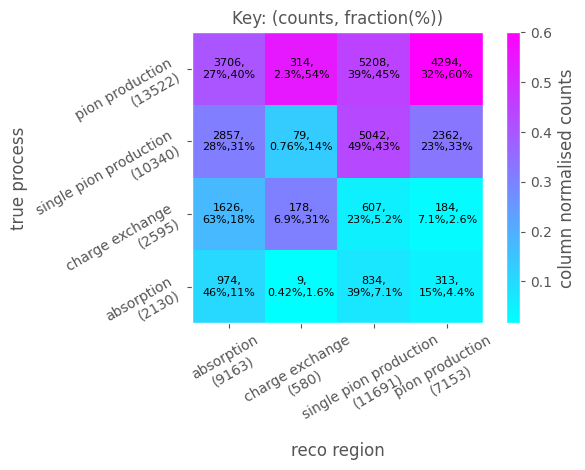

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 1, 'channel_1': 1, 'channel_2': 1, 'channel_3': 1}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_stat_err', 'staterror'), ('channel_1_stat_err', 'staterror'), ('channel_2_stat_err', 'staterror'), ('channel_3_stat_err', 'staterror'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor')]
parameters: ['channel_0_stat_err', 'channel_1_stat_err', 'channel_2_stat_err', 'channel_3_stat_err', 'mu_0', 'mu_1', 'mu_2', 'mu_3']
  nauxdata: 4
   auxdata: [1.0, 1.0, 1.0, 1.0]
model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-23364.47015403])


[2.67739274 1.15397213 0.6161062  0.79595799]

[0.85267329 0.29365919 0.23363262 0.11626768]

In [24]:
def replace_region(data_region, mc_region):
    ai_mc_copy = CopyAnalysisInput(ai["mc"])
    ai_mc_copy.regions = mc_region

    ai_data_copy = CopyAnalysisInput(ai["data"])
    ai_data_copy.regions = data_region

    return ai_data_copy, ai_mc_copy

def Test(data_regions, mc_regions):
    counts = cross_section.CountInRegions(mc_true_regions, mc_regions)
    Plots.PlotConfusionMatrix(counts, list(mc_regions.keys()), list(mc_regions.keys()), y_label = "true process", x_label = "reco region", newFigure = True)
    Plots.plt.show()
    data, mc = replace_region(data_regions, mc_regions)
    results = run_fit(data, mc)
    return results, data

#* veto photons in abs and spip
reco_regions_data_gamma_veto = gamma_veto(data_reco_regions, data_region_properties["n_photon"])
reco_regions_mc_gamma_veto = gamma_veto(mc_reco_regions, mc_region_properties["n_photon"])

#* veto photons in abs and spip, move spip to pip
reco_regions_data_gamma_veto_spip = gamma_veto_spip_migrate(data_reco_regions, reco_regions_data_gamma_veto, data_region_properties["n_photon"], "pion_production")
reco_regions_mc_gamma_veto_spip = gamma_veto_spip_migrate(mc_reco_regions, reco_regions_mc_gamma_veto, mc_region_properties["n_photon"], "pion_production")

#* veto poor pfos in cex
reco_regions_data_poor_pfo = regions_cex(data_reco_regions, data_region_properties["poor_pfo_counts"], data_region_properties["poor_photon_counts"])
reco_regions_mc_poor_pfo = regions_cex(mc_reco_regions, mc_region_properties["poor_pfo_counts"], mc_region_properties["poor_photon_counts"])

#* veto poor pfos in cex, veto photons in abs and spip
reco_regions_data_poor_pfo_gamma_veto = gamma_veto(reco_regions_data_poor_pfo, data_region_properties["n_photon"])
reco_regions_mc_poor_pfo_gamma_veto = gamma_veto(reco_regions_mc_poor_pfo, mc_region_properties["n_photon"])


#* veto poor pfos in cex, veto photons in abs and spip, move spip to pip
reco_regions_data_poor_pfo_gamma_veto_spip = regions_cex(reco_regions_data_gamma_veto_spip, data_region_properties["poor_pfo_counts"], data_region_properties["poor_photon_counts"])
reco_regions_mc_poor_pfo_gamma_veto_spip = regions_cex(reco_regions_mc_gamma_veto_spip, mc_region_properties["poor_pfo_counts"], mc_region_properties["poor_photon_counts"])

#* veto poor pfos in cex, veto photons in abs and spip, move spip to pip, move abs to cex
reco_regions_data_poor_pfo_gamma_veto_spip_cex = regions_cex(gamma_veto_abs_migrate(data_reco_regions, reco_regions_data_gamma_veto_spip, data_region_properties["n_photon"], "charge_exchange"), data_region_properties["poor_pfo_counts"], data_region_properties["poor_photon_counts"])
reco_regions_mc_poor_pfo_gamma_veto_spip_cex = regions_cex(gamma_veto_abs_migrate(mc_reco_regions, reco_regions_mc_gamma_veto_spip, mc_region_properties["n_photon"], "charge_exchange"), mc_region_properties["poor_pfo_counts"], mc_region_properties["poor_photon_counts"])


print(Rule("normal"))
results = Test(data_reco_regions, mc_reco_regions)

# print(Rule("photon veto"))
# Test(reco_regions_data_gamma_veto, reco_regions_mc_gamma_veto)

# print(Rule("photon veto, spip to pip"))
# Test(reco_regions_data_gamma_veto_spip, reco_regions_mc_gamma_veto_spip)

# print(Rule("poor pfo in cex"))
# Test(reco_regions_data_poor_pfo, reco_regions_mc_poor_pfo)

# print(Rule("gamma veto, poor pfo in cex"))
# Test(reco_regions_data_poor_pfo_gamma_veto, reco_regions_mc_poor_pfo_gamma_veto)

# print(Rule("gamma veto, poor pfo in cex, spip to pip"))
# Test(reco_regions_data_poor_pfo_gamma_veto_spip, reco_regions_mc_poor_pfo_gamma_veto_spip)

# print(Rule("gamma veto, poor pfo in cex, spip to pip, abs to cex"))
# Test(reco_regions_data_poor_pfo_gamma_veto_spip_cex, reco_regions_mc_poor_pfo_gamma_veto_spip_cex)


In [28]:
print(results[0][0].model)

<pyhf.pdf.Model object at 0x7fec70a336d0>

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-23364.47015403])


array([2.5556e+04, 1.4480e+03, 2.8802e+04, 1.6974e+04, 1.0000e+00,
       1.0000e+00, 1.0000e+00, 1.0000e+00])

In [42]:
results[0][0].model.config.par_names

['mu_0',
 'mu_1',
 'mu_2',
 'mu_3',
 'channel_0_stat_err[0]',
 'channel_1_stat_err[0]',
 'channel_2_stat_err[0]',
 'channel_3_stat_err[0]']

In [139]:
from python.analysis import cross_section
# CLs_obs, CLs_exp = cross_section.pyhf.infer.hypotest(
#     1.0,  # null hypothesis
#     cross_section.RegionFit.GenerateObservations(results[1], args.energy_slices, None, results[0][0].model, single_bin = args.fit["single_bin"]),
#     results[0][0].model,
#     test_stat="qtilde",
#     return_expected_set=True,
# )
# print(f"      Observed CLs: {CLs_obs:.4f}")
# for expected_value, n_sigma in zip(CLs_exp, np.arange(-2, 3)):
#     print(f"Expected CLs({n_sigma:2d} σ): {expected_value:.4f}")

cross_section.cabinetry.fit.significance(
    results[0][0].model,
    cross_section.RegionFit.GenerateObservations(results[1], args.energy_slices, None, results[0][0].model, single_bin = args.fit["single_bin"]),
    poi_name = "mu_0",
    maxiter = int(1E6)
    )

# cross_section.cabinetry.visualize.limit(
#     cross_section.cabinetry.fit.limit(
#         results[0][0].model,
#         cross_section.RegionFit.GenerateObservations(results[1], args.energy_slices, None, results[0][0].model, single_bin = args.fit["single_bin"]),
#         poi_name = "mu_1",
#         bracket = [0.01, 15],
#         par_bounds = [[0, 15]]*8,
#         confidence_level = 0.95
#         ), save_figure = False
# )

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
model.logpdf(pars=model.config.suggested_init(), data=observations)=array([-23364.47015403])


SignificanceResults(observed_p_value=0.6044251727272703, observed_significance=-0.2648180198039031, expected_p_value=0.3455354854136401, expected_significance=0.3974020950251231)